In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scalarhadronizer import ScalarHadronizer
from particle import Particle as p
#using the hipsofcobra code to generate pi+pi- and K+K- decay widths, see https://arxiv.org/pdf/2407.13587
#from hipsofcobra import HipsofCobra
import pickle
import os
plt.style.use('plotstyle.mplstyle')

# pi and K decay widths from literature

In [2]:
#hips_pi = HipsofCobra( clist=[1,1,1], Pname='pi', method='DGL')
#hips_pi.write_widths()
pi_data=np.loadtxt('hipsofcobra/clist=[1, 1, 1]/widths_data_c=[1, 1, 1]_pi_method=DGL.csv',delimiter=',',skiprows=1)
m=pi_data[:,0]
gamma_pi_central=pi_data[:,1][m==2.0][0]
gamma_pi_lower=pi_data[:,2][m==2.0][0]
gamma_pi_upper=pi_data[:,3][m==2.0][0]
pi_width_2GeV=gamma_pi_central
print(pi_width_2GeV)

5.008185005808889e-08


In [3]:
#hips_K = HipsofCobra( clist=[1,1,1], Pname='K', method='DGL')
#hips_K.write_widths()
K_data=np.loadtxt('hipsofcobra/clist=[1, 1, 1]/widths_data_c=[1, 1, 1]_K_method=DGL.csv',delimiter=',',skiprows=1)
m=K_data[:,0]
gamma_K_central=K_data[:,1][m==2.0][0]
gamma_K_lower=K_data[:,2][m==2.0][0]
gamma_K_upper=K_data[:,3][m==2.0][0]
K_width_2GeV=gamma_K_central

print(K_width_2GeV)

1.310270241863413e-07


In [ ]:
#from own calculation of gluonic decay width
#hadronic_decay_width_2GeV=1.5294102825483557e-07

"""
gamma_tot_central=1.5294102825483557e-07
gamma_tot_lower=8.402010413558565e-08
gamma_tot_upper=3.8896142800792654e-07
hadronic_decay_width_2GeV=gamma_tot_central
pi_branching_ratio=pi_width_2GeV/hadronic_decay_width_2GeV
print(f'Pi branching ratio: {pi_branching_ratio}')
K_branching_ratio=K_width_2GeV/hadronic_decay_width_2GeV
print(f'K branching ratio: {K_branching_ratio}')
print(f'Sum: {pi_branching_ratio+K_branching_ratio}')
"""

Pi branching ratio: 0.3274585677208917
K branching ratio: 0.8567159883874953
Sum: 1.184174556108387


In [5]:
gamma_tot_NNLO_central=2.48023368e-07
gamma_tot_NNLO_lower=1.44417714e-07
gamma_tot_NNLO_upper=5.13730053e-07

In [4]:
gamma_K_central_last=K_data[-1,1]
gamma_K_lower_last=K_data[-1,2]
gamma_K_upper_last=K_data[-1,3]
gamma_pi_central_last=pi_data[-1,1]
gamma_pi_lower_last=pi_data[-1,2]
gamma_pi_upper_last=pi_data[-1,3]

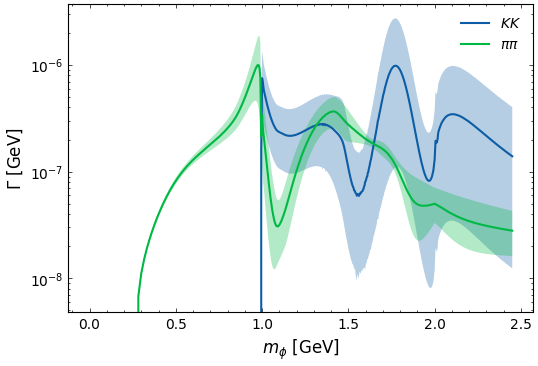

In [46]:
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(K_data[:,0],K_data[:,1],label=r'$KK$')
ax.fill_between(K_data[:,0], K_data[:,2],K_data[:,3],alpha=0.3,interpolate=True)
ax.plot(pi_data[:,0],pi_data[:,1],label=r'$\pi\pi$')
ax.fill_between(pi_data[:,0], pi_data[:,2],pi_data[:,3],alpha=0.3,interpolate=True)
ax.set_yscale('log')
ax.set_xlabel(r'$m_{\phi}$ [GeV]')
ax.set_ylabel(r'$\Gamma$ [GeV]')
ax.legend()
plt.savefig('/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/dispersive_result.pdf')

Generated 38 initial meson pairs.
The following initial states were generated:
K*(892)-[-323] K*(892)+[-323]: 0.10575449404597223
K*(892)~0[-313] K*(892)0[-313]: 0.10505698030416057
omega(782)[223] omega(782)[223]: 0.07460485116397067
omega(782)[223] h(1)(1415)[223]: 0.06510225328519126
omega(782)[223] phi(1020)[223]: 0.06293283462152438
omega(782)[223] h(1)(1170)[223]: 0.05333319188866702
rho(770)-[-213] rho(770)+[-213]: 0.04964538315716953
phi(1020)[333] phi(1020)[333]: 0.047119567198943633
K-[-321] K+[-321]: 0.03361036070668834
K~0[-311] K0[-311]: 0.03354955612576682
phi(1020)[333] h(1)(1170)[333]: 0.03166811473720199
omega(782)[223] omega(1420)[223]: 0.029578107824446254
eta[221] f(1)(1420)[221]: 0.02795895845982472
rho(770)0[113] rho(770)0[113]: 0.02481869193700363
eta[221] eta[221]: 0.019894907610377443
eta[221] f(1)(1285)[221]: 0.01949154461579217
eta[221] eta(1475)[221]: 0.017144262851156285
eta[221] eta(2)(1645)[221]: 0.016915379174798538
eta[221] eta'(958)[221]: 0.01683159929

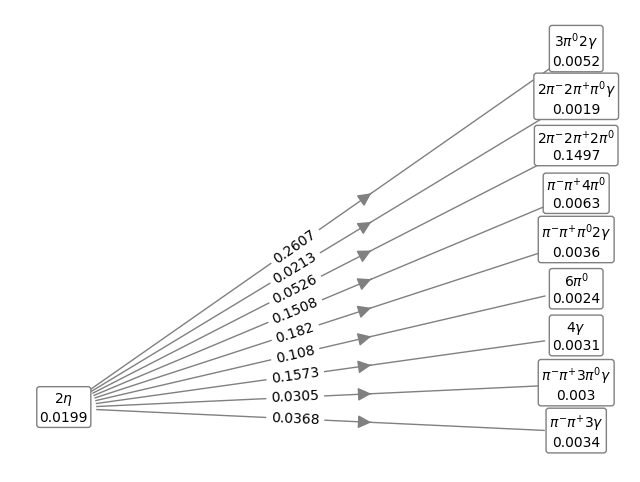

{(310, 310): 1, (-213, 213): 1, (111, 20113): 2, (-211, 111, 111, 211): 0, (9010221, 9010221): 1, (-211, 111, 213): 1, (-213, 111, 211): 1, (-311, 311): 2, (225, 9010221): 1}


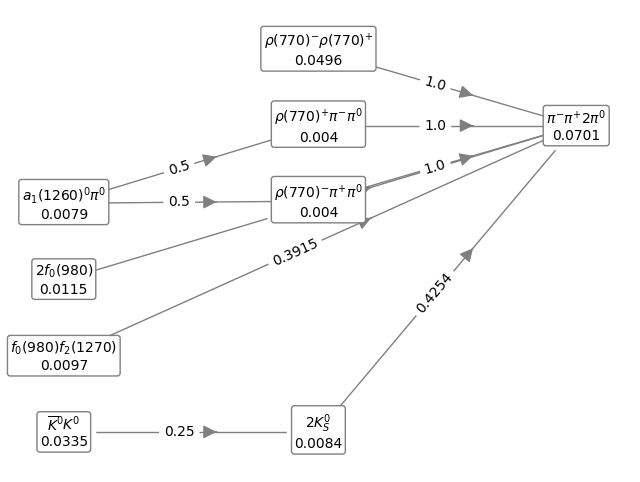

In [36]:
#Plot of a graph for the thesis:
SH=ScalarHadronizer(2300,strange_weight=1,spin_suppression=0.5)
decay_graph=SH.simulateDecay()
SH.print_initial_states()
SH.print_final_states(10,decay_graph)
SH.plot_from_initial_state(decay_graph,(221,221))
SH.plot_from_final_state(decay_graph,(-211,111,111,211),path='/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/graph.pdf')

# Scalar resonances?

In [94]:
scalar_resonances=p.findall(lambda p: p.J==0 and p.C==1 and p.P==1)# and p.I==0)
for s in scalar_resonances:
    print(s.name,s.mass,s.J)
    dec=SH.single_particle_decays(s.pdgid)
    if (-211,211) in dec:
        print(f'\t pi+pi- br: {dec[(-211,211)]}')
    if (211,-211) in dec:
        print(f'\t pi+pi- br: {dec[(211,-211)]}')

    if (-321,321) in dec:
        print(f'\t K+K- br: {dec[(-321,321)]}')
    if (321,-321) in dec:
        print(f'\t K+K- br: {dec[(321,-321)]}')


a(0)(1450)0 1439.0 0.0
f(0)(1370) 1350.0 0.0
	 pi+pi- br: 0.5200000000000001
	 K+K- br: 0.03500000000000001
f(0)(1710) 1733.0 0.0
chi(c0)(1P) 3414.71 0.0
chi(b0)(1P) 9859.4 0.0
chi(b0)(2P) 10232.5 0.0
a(0)(980)0 980.0 0.0
	 K+K- br: 0.05
f(0)(500) 600.0 0.0
f(0)(980) 990.0 0.0
	 pi+pi- br: 0.6667
f(0)(1500) 1522.0 0.0
	 pi+pi- br: 0.23300000000000004
	 K+K- br: 0.043000000000000003
f(0)(2020) 1982.0 0.0


Since the widths of f(1370) and f(1500) are not very big (from pdg) they shouldnt affect the pi+pi- or K+K- brs too much, so its probably unnecessary to implement resonances in the model. Note: pdg doesn't list the branching ratios above for f(1370)

# Likelihood fit (with fitted pdfs)
(probably not the best way to do it)


In [7]:
def p_restframe(M,m1,m2):
    return np.sqrt((M**2-(m1+m2)**2)*(M**2-(m1-m2)**2))/2/M

print(p_restframe(2000,4,4),p_restframe(2000,2,2))

999.9919999679997 999.997999998


In [1]:
import scipy.optimize as optimize
SH1=ScalarHadronizer(2000,1,1,1,1,1,1)

def init_make_initialMesonPairs(self):
    mesons_below_threshold=p.findall(lambda p: p.mass<2000 and p.pdgid.is_meson==True)
    meson_pairs={}
    total_weight=0
    for i,m1 in enumerate(mesons_below_threshold):
        for m2 in mesons_below_threshold[i:]:
            if self.check_meson_combinations(m1,m2,self.scalar_mass):
                weight=self.initialWeight(m1,m2,1,1,1,1,1,1)
                if m1.pdgid<m2.pdgid: meson_pairs[(m1,m2)]=weight
                else: meson_pairs[(m2,m1)]=weight
                total_weight+=weight
    meson_pairs={k:v/total_weight for k,v in meson_pairs.items()}
    return meson_pairs

def update_init_weights(self,init_meson_pairs,strange_weight,OAM_supression_par):
    meson_pairs={}
    total_weight=0
    for m1,m2 in init_meson_pairs:
            weight=self.initialWeight(m1,m2,1,1,strange_weight,0,0,OAM_supression_par)
            if m1.pdgid<m2.pdgid: meson_pairs[(int(m1.pdgid),int(m2.pdgid))]=weight
            else: meson_pairs[(int(m2.pdgid),int(m1.pdgid))]=weight
            total_weight+=weight
    meson_pairs={k:v/total_weight for k,v in meson_pairs.items()}
    return meson_pairs

meson_pairs=init_make_initialMesonPairs(SH1)

def p_restframe(M,m1,m2):
    return np.sqrt((M**2-(m1+m2)**2)*(M**2-(m1-m2)**2))/2/M

K_p=p.findall('K+')[0]
K0=p.findall('K0')[0]
pi0=p.findall('pi0')[0]
pi_p=p.findall('pi+')[0]

def strange_weight(gamma_pi,gamma_K):
    return gamma_K*(p_restframe(2000,pi0.mass,pi0.mass)+2*p_restframe(2000,pi_p.mass,pi_p.mass))/(3*gamma_pi*(p_restframe(2000,K0.mass,K0.mass)+p_restframe(2000,K_p.mass,K_p.mass)))

def pi_K_brs_2GeV(ws,wv):
    pairs=update_init_weights(SH1,meson_pairs,ws,wv)
    br_pi=pairs[(-211,211)]+pairs[(111,111)]
    br_K=pairs[(-321,321)]+pairs[(-311,311)]
    return br_pi,br_K


NameError: name 'ScalarHadronizer' is not defined

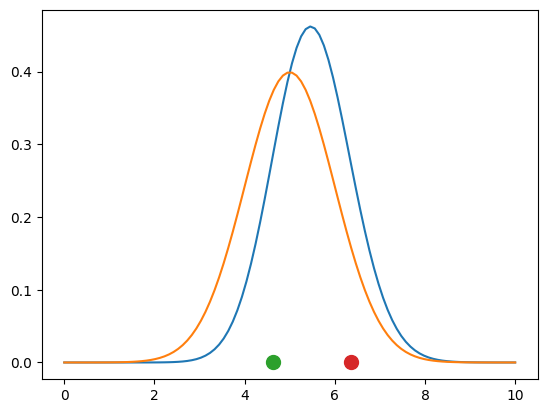

In [8]:
from scipy.stats import skewnorm,norm
x=np.linspace(0,10,100)
xi=5
alpha=0.8
omega=1
plt.plot(x,skewnorm.pdf(x,alpha,loc=xi,scale=omega))
plt.plot(x,norm.pdf(x,loc=xi))
p1=skewnorm.ppf(0.16,alpha,loc=xi,scale=omega)
p2=skewnorm.ppf(0.84,alpha,loc=xi,scale=omega)
plt.plot(p1,0,'o',markersize=10)
plt.plot(p2,0,'o',markersize=10)

In [9]:
def fit_skewnorm(x,scaling=1):
    loc=x[0]
    scale=x[1]
    skew=x[2]
    mean=skewnorm.mean(skew,loc=loc,scale=scale)
    median=skewnorm.median(skew,loc=loc,scale=scale)
    return [skewnorm.cdf(gamma_pi_lower*scaling,skew,loc=loc,scale=scale)-0.16,skewnorm.cdf(gamma_pi_upper*scaling,skew,loc=loc,scale=scale)-0.84,median-gamma_pi_central*scaling]

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 9.577e-11 -1.332e-10  4.904e-11]
           x: [ 4.378e+00  1.041e+00  1.332e+00]
        cost: 1.4660893626010036e-20
         jac: [[-3.867e-02  3.975e-02 -2.652e-02]
               [-2.779e-02 -7.157e-02 -1.159e-05]
               [ 1.000e+00  6.053e-01  1.369e-01]]
        grad: [ 4.904e-11  4.303e-11  4.177e-12]
  optimality: 4.903904632747108e-11
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 9
        njev: 8
0.2852381953741676
0.17353078237537667


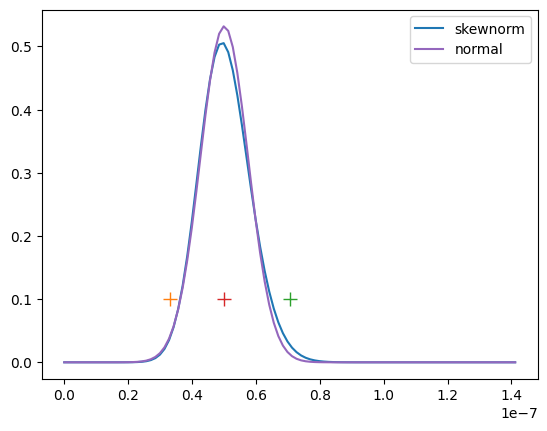

In [10]:
from scipy import optimize
from scipy.stats import skewnorm,norm
def fit_skewnorm_pi(x,scaling=1):
    loc=x[0]
    scale=x[1]
    skew=x[2]
    mean=skewnorm.mean(skew,loc=loc,scale=scale)
    median=skewnorm.median(skew,loc=loc,scale=scale)
    return [skewnorm.cdf(gamma_pi_lower*scaling,skew,loc=loc,scale=scale)-0.01,skewnorm.cdf(gamma_pi_upper*scaling,skew,loc=loc,scale=scale)-0.99,median-gamma_pi_central*scaling]

scaling=1e8
res=optimize.least_squares(fit_skewnorm_pi,x0=(1,1,0),args=(scaling,))
print(res)
x=np.linspace(0,gamma_pi_upper*2,100)
plt.plot(x,skewnorm.pdf(scaling*x,res.x[2],loc=res.x[0],scale=res.x[1]),label='skewnorm')
plt.plot(gamma_pi_lower,0.1,'+',markersize=10)
plt.plot(gamma_pi_upper,0.1,'+',markersize=10)
plt.plot(gamma_pi_central,0.1,'+',markersize=10)

plt.plot(x,1/scaling*norm.pdf(x,loc=gamma_pi_central,scale=(gamma_pi_upper-gamma_pi_lower)/5),label='normal')
plt.legend()
print(abs(1-skewnorm.ppf(0.16,res.x[2],loc=res.x[0],scale=res.x[1])/gamma_pi_lower*1e-8))
print(abs(1-skewnorm.ppf(0.84,res.x[2],loc=res.x[0],scale=res.x[1])/gamma_pi_upper*1e-8))

     message: The maximum number of function evaluations is exceeded.
     success: False
      status: 0
         fun: [-9.808e-03  5.588e-03 -1.234e-03]
           x: [ 3.196e+00  4.427e+00]
        cost: 6.446996196525358e-05
         jac: [[-2.485e-04 -5.014e-04]
               [-1.206e-02 -5.306e-03]
               [ 4.099e+00  3.193e+00]]
        grad: [-5.122e-03 -3.964e-03]
  optimality: 0.18063195613521632
 active_mask: [0 0]
        nfev: 200
        njev: 150
2.332039609392891
0.17865059512638826


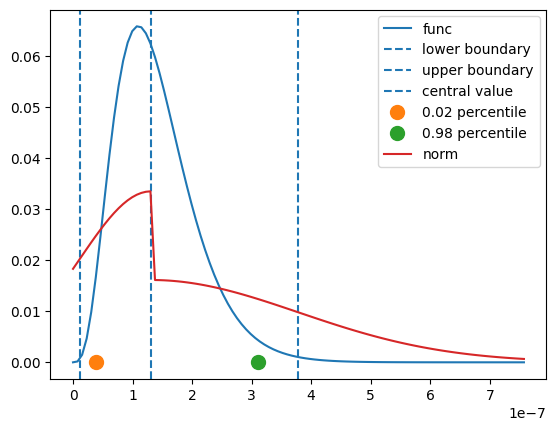

In [11]:
from scipy.stats import gamma,chi
def fit_func_K(x,scaling=1,func=gamma):
    #loc=x[0]
    scale=x[0]
    skew=x[1]
    #loc=x[2]
    loc=0
    mean=func.mean(skew,loc=loc,scale=scale)
    median=func.median(skew,loc=loc,scale=scale)
    return [func.cdf(gamma_K_lower*scaling,skew,loc=loc,scale=scale)-0.01,func.cdf(gamma_K_upper*scaling,skew,loc=loc,scale=scale)-0.99,median-gamma_K_central*scaling]

def fit_gamma_K2(x,scaling=1):
    loc=0
    scale=x[0]
    skew=x[1]
    median=gamma.median(skew,loc=loc,scale=scale)
    mean=func.mean(skew,loc=loc,scale=scale)
    return mean-gamma_K_central*scaling
scaling=1e8
func=gamma
#res_K=optimize.least_squares(fit_func_K,x0=(0,1,1),args=(scaling,),bounds=([0,0,0],[np.inf,np.inf,50]))
res_K=optimize.least_squares(fit_func_K,x0=(1,1),args=(scaling,),bounds=([0,0],[np.inf,50]))
#res_K=optimize.least_squares(fit_gamma_K2,x0=(1,1),args=(scaling,),bounds=([1,0],[50,np.inf]))
print(res_K)
if len(res_K.x)<3: loc=0
else: loc=res_K.x[2]
x=np.linspace(0,gamma_K_upper*2,100)
plt.plot(x,func.pdf(scaling*x,res_K.x[1],loc=loc,scale=res_K.x[0]),label='func')
plt.axvline(gamma_K_lower,linestyle='--',label='lower boundary')
plt.axvline(gamma_K_upper,linestyle='--',label='upper boundary')
plt.axvline(gamma_K_central,linestyle='--',label='central value')
plt.plot(func.ppf(0.02,res_K.x[1],loc=loc,scale=res_K.x[0])/scaling,0,'o',markersize=10,label='0.02 percentile')
plt.plot(func.ppf(0.98,res_K.x[1],loc=loc,scale=res_K.x[0])/scaling,0,'o',markersize=10,label='0.98 percentile')
#plt.plot(x,1/scaling*norm.pdf(x,loc=gamma_K_central,scale=(gamma_K_upper-gamma_K_lower)/4),label='norm')
plt.plot(x,1/scaling*np.where(x<gamma_K_central,norm.pdf(x,loc=gamma_K_central,scale=gamma_K_central-gamma_K_lower),norm.pdf(x,loc=gamma_K_central,scale=gamma_K_upper-gamma_K_central)),label='norm')
plt.legend()
#plt.xscale('log')
print(abs(1-func.ppf(0.02,res_K.x[1],loc=loc,scale=res_K.x[0])/gamma_K_lower*1e-8))
print(abs(1-func.ppf(0.98,res_K.x[1],loc=loc,scale=res_K.x[0])/gamma_K_upper*1e-8))


     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-1.041e-17  0.000e+00 -1.776e-15]
           x: [ 6.317e+00  1.501e+00  7.817e+00]
        cost: 1.5777759772217095e-30
         jac: [[-4.577e-03 -6.197e-02 -4.946e-02]
               [-1.424e-02 -3.482e-02 -2.895e-03]
               [ 1.184e+00  6.236e+00  1.000e+00]]
        grad: [-2.102e-15 -1.108e-14 -1.776e-15]
  optimality: 1.1077078451091316e-14
 active_mask: [0 0 0]
        nfev: 31
        njev: 23
0.6369866978266174
0.4212045467826073


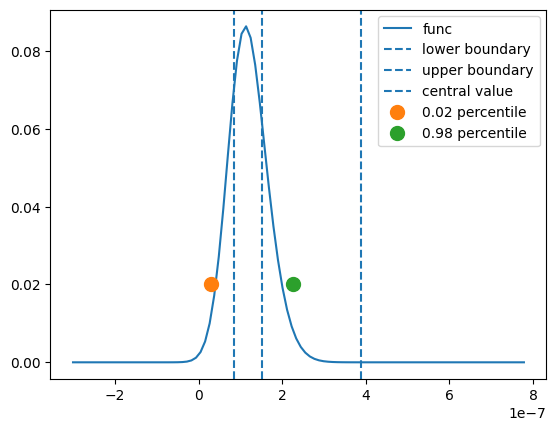

In [12]:
from scipy.stats import gamma,chi2,chi
def fit_func_gamma_tot(x,scaling=1,func=gamma):
    loc=x[2]
    scale=x[0]
    skew=x[1]
    mean=func.mean(skew,loc=loc,scale=scale)
    median=func.median(skew,loc=loc,scale=scale)
    return [func.cdf(gamma_tot_lower*scaling,skew,loc=loc,scale=scale)-0.02,func.cdf(gamma_tot_upper*scaling,skew,loc=loc,scale=scale)-0.98,median-gamma_tot_central*scaling]

scaling=1e8
func=skewnorm
#res_gamma=optimize.least_squares(fit_func_gamma_tot,x0=(1,1),args=(scaling,),bounds=([0,0],[np.inf,50]))
res_gamma=optimize.least_squares(fit_func_gamma_tot,x0=(1,1,0),args=(scaling,),bounds=([0,0,0],[np.inf,np.inf,np.inf]))
print(res_gamma)
if len(res_gamma.x)<3: loc=0
else: loc=res_gamma.x[2]
x=np.linspace(-3e-7,gamma_tot_upper*2,100)
plt.plot(x,func.pdf(scaling*x,res_gamma.x[1],loc=loc,scale=res_gamma.x[0]),label='func')
plt.axvline(gamma_tot_lower,linestyle='--',label='lower boundary')
plt.axvline(gamma_tot_upper,linestyle='--',label='upper boundary')
plt.axvline(gamma_tot_central,linestyle='--',label='central value')
plt.plot(func.ppf(0.02,res_gamma.x[1],loc=loc,scale=res_gamma.x[0])/scaling,0.02,'o',markersize=10,label='0.02 percentile')
plt.plot(func.ppf(0.98,res_gamma.x[1],loc=loc,scale=res_gamma.x[0])/scaling,0.02,'o',markersize=10,label='0.98 percentile')


#plt.plot(x,1/scaling*norm.pdf(x,loc=gamma_tot_central,scale=(gamma_tot_upper-gamma_tot_lower)/2),label='norm')
plt.legend()
print(abs(1-func.ppf(0.02,res_gamma.x[1],loc=loc,scale=res_gamma.x[0])/gamma_tot_lower*1e-8))
print(abs(1-func.ppf(0.98,res_gamma.x[1],loc=loc,scale=res_gamma.x[0])/gamma_tot_upper*1e-8))

In [100]:
def nll(theta,mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot):
    ws=theta[0]
    wv=theta[1]
    gamma_tot=theta[2]
    br_pi,br_K=pi_K_brs_2GeV(ws,wv)
    gamma_pi=br_pi*gamma_tot
    gamma_K=br_K*gamma_tot
    scaling=1e8
    return (gamma_pi-mu_pi)**2/(2*sigma_pi**2) - (a_K-1)*np.log(gamma_K/omega_K) - (a_tot-1)*np.log(gamma_tot/omega_tot) + gamma_K/omega_K + gamma_tot/omega_tot

mu_pi=gamma_pi_central*scaling
sigma_pi=(gamma_pi_upper-gamma_pi_lower)/5*scaling
a_K=res_K.x[1]
omega_K=res_K.x[0]
a_tot=res_gamma.x[1]
omega_tot=res_gamma.x[0]

nll([1,0.2,gamma_tot_central],mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot)

np.float64(358.0814395207578)

In [250]:
res_nll=optimize.minimize(nll,(1,0.2,gamma_tot_central*scaling),args=(mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot),bounds=[(0,10),(0,1),(0,gamma_tot_upper*2*scaling)],method='Nelder-Mead')
ws_min=res_nll.x[0]
wv_min=res_nll.x[1]
gamma_tot_min=res_nll.x[2]/scaling
res_nll

/tmp/ipykernel_22419/1104610515.py:9: RuntimeWarning: divide by zero encountered in log
  return (gamma_pi-mu_pi)**2/(2*sigma_pi**2) - (a_K-1)*np.log(gamma_K/omega_K) - (a_tot-1)*np.log(gamma_tot/omega_tot) + gamma_K/omega_K + gamma_tot/omega_tot


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -31.35810968373024
             x: [ 5.310e-01  0.000e+00  1.944e+01]
           nit: 117
          nfev: 204
 final_simplex: (array([[ 5.310e-01,  0.000e+00,  1.944e+01],
                       [ 5.310e-01,  0.000e+00,  1.944e+01],
                       [ 5.310e-01,  0.000e+00,  1.944e+01],
                       [ 5.310e-01,  0.000e+00,  1.944e+01]]), array([-3.136e+01, -3.136e+01, -3.136e+01, -3.136e+01]))

In [194]:
print(res_nll.message)
print(f'L: {res_nll.fun}')
print(f'Parameters:')
print(f'\t ws: {res_nll.x[0]}')
print(f'\t wv: {res_nll.x[1]} ')
print(f'\t gamma_tot: {res_nll.x[2]/scaling}, distance to central value: {1-res_nll.x[2]/scaling/gamma_tot_central}')
print('resulting decay widths:')
br_pi,br_K=pi_K_brs_2GeV(res_nll.x[0],res_nll.x[1])
print(f'br_pi: {br_pi}, gamma_pi: {br_pi*res_nll.x[2]/scaling}, distrance to central value: {1-br_pi*res_nll.x[2]/scaling/gamma_pi_central}')
print(f'br_K: {br_K}, gamma_K: {br_K*res_nll.x[2]/scaling}, distrance to central value: {1-br_K*res_nll.x[2]/scaling/gamma_K_central}')
print(f'')

Optimization terminated successfully.
L: -31.35810968373024
Parameters:
	 ws: 0.5309985875301801
	 wv: 0.0 
	 gamma_tot: 1.9440276023265107e-07, distance to central value: -0.27109620257509026
resulting decay widths:
br_pi: 0.2354134771980641, gamma_pi: 4.5765029763269924e-08, distrance to central value: 0.08619530408345488
br_K: 0.22145190159419254, gamma_K: 4.305086092868045e-08, distrance to central value: 0.6714352539407804



/tmp/ipykernel_22419/1104610515.py:9: RuntimeWarning: divide by zero encountered in log
  return (gamma_pi-mu_pi)**2/(2*sigma_pi**2) - (a_K-1)*np.log(gamma_K/omega_K) - (a_tot-1)*np.log(gamma_tot/omega_tot) + gamma_K/omega_K + gamma_tot/omega_tot


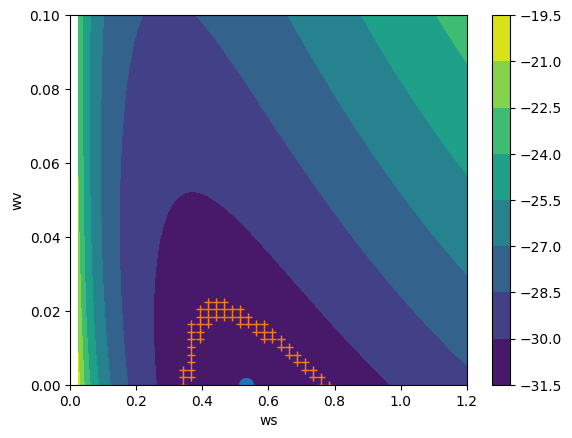

In [170]:
ws=np.linspace(0,1.2,50)
wv=np.linspace(0,0.1,50)
gamma_tot=np.linspace(0,gamma_tot_upper*2,50)
X,Y=np.meshgrid(ws,wv)
nll_const_gamma=np.vectorize(lambda x,y: nll([x,y,res_nll.x[2]],mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot))(X,Y)
plt.contourf(X,Y,nll_const_gamma)
plt.colorbar()
plt.xlabel('ws')
plt.ylabel('wv')
plt.plot(res_nll.x[0],res_nll.x[1],'o',markersize=10)
mask=np.abs(nll_const_gamma-0.5-res_nll.fun)<8e-2
plt.plot(X[mask],Y[mask],'+')

/tmp/ipykernel_22419/1104610515.py:9: RuntimeWarning: divide by zero encountered in log
  return (gamma_pi-mu_pi)**2/(2*sigma_pi**2) - (a_K-1)*np.log(gamma_K/omega_K) - (a_tot-1)*np.log(gamma_tot/omega_tot) + gamma_K/omega_K + gamma_tot/omega_tot


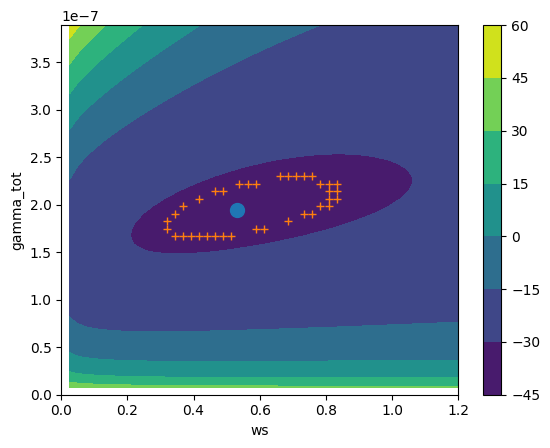

In [197]:
ws=np.linspace(0,1.2,50)
wv=np.linspace(0,0.1,50)
gamma_tot=np.linspace(0,gamma_tot_upper,50)
X,Y=np.meshgrid(ws,gamma_tot)
nll_const_wv=np.vectorize(lambda x,y: nll([x,res_nll.x[1],y*scaling],mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot))(X,Y)
plt.contourf(X,Y,nll_const_wv)
plt.colorbar()
plt.xlabel('ws')
plt.ylabel('gamma_tot')
plt.plot(res_nll.x[0],res_nll.x[2]/scaling,'o',markersize=10)
mask=np.abs(nll_const_wv-0.5-res_nll.fun)<8e-2
plt.plot(X[mask],Y[mask],'+')

/tmp/ipykernel_22419/1104610515.py:9: RuntimeWarning: divide by zero encountered in log
  return (gamma_pi-mu_pi)**2/(2*sigma_pi**2) - (a_K-1)*np.log(gamma_K/omega_K) - (a_tot-1)*np.log(gamma_tot/omega_tot) + gamma_K/omega_K + gamma_tot/omega_tot


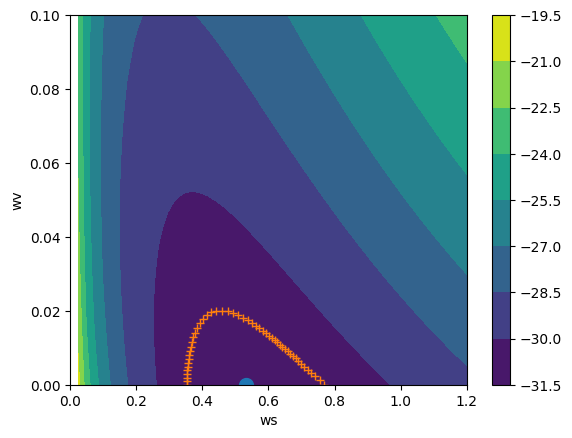

In [ ]:
ws_contour=[]
wv_contour=[]
for phi in np.linspace(0,np.pi,40):
    aspect_ratio=0.1/1.2
    root=optimize.root_scalar(lambda r: nll([r*np.cos(phi)+res_nll.x[0],(r*np.sin(phi)+res_nll.x[1])*aspect_ratio,res_nll.x[2]],mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot)-res_nll.fun-0.5,bracket=[0,np.sqrt(res_nll.x[0]**2+res_nll.x[1]**2)])
    ws_contour.append(root.root*np.cos(phi)+res_nll.x[0])
    wv_contour.append((root.root*np.sin(phi)+res_nll.x[1])*aspect_ratio)


plt.contourf(X,Y,Z)
plt.colorbar()
plt.xlabel('ws')
plt.ylabel('wv')
plt.plot(res_nll.x[0],res_nll.x[1],'o',markersize=10)
plt.plot(ws_contour,wv_contour,'+')


-3.141592653589793 0.53099858753018
-3.0133643820146996 0.4031214258456741
-2.885136110439606 0.2773440036206729
-2.7569078388645125 0.15573158265080675
-2.628679567289419 0.04028103552625017
-2.500451295714325 0.5309985875301816
-2.3722230241392315 0.530998587530183
-2.243994752564138 0.5309985875301853
-2.1157664809890444 0.5309985875301885
-1.9875382094139509 0.5309985875301928
-1.8593099378388573 0.5309985875301984
-1.7310816662637636 0.5309985875302053
-1.60285339468867 0.5309985875302136
-1.4746251231135765 0.5309985875302229
-1.3463968515384828 0.5309985875302333
-1.2181685799633892 0.5309985875302445
-1.0899403083882957 0.5309985875302563
-0.9617120368132022 0.5309985875302682
-0.8334837652381086 0.5309985875302797
-0.7052554936630151 0.5309985875302905
-0.5770272220879216 0.5309985875303004
-0.4487989505128276 0.09711484841332516
-0.32057067893773405 0.21589036950689194
-0.19234240736264052 0.339839958829026
-0.06411413578754699 0.4669283675496286
0.06411413578754654 0.5950688

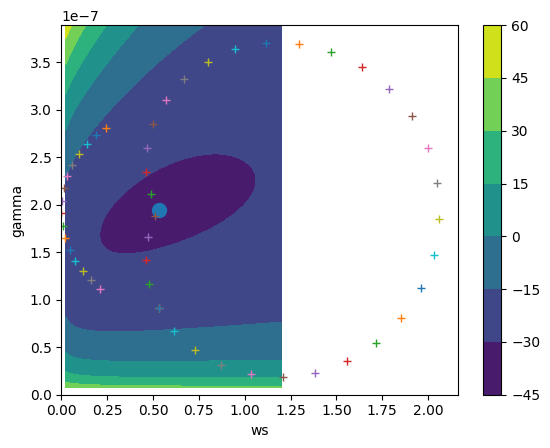

In [281]:
ws_list=[]
wv_list=[]
for phi in np.linspace(0,np.pi,50):
    aspect_ratio=gamma_tot_upper/1.2*scaling
    R=np.sqrt(ws**2+(gamma_tot_min)**2)
    ws=1*np.cos(phi)+ws_min
    gamma=(gamma_tot_upper*np.sin(phi)+gamma_tot_min)
    ws_list.append(ws)
    wv_list.append(gamma)

def get_upper_bound(theta,phi):
    vec=param_vec(1,theta,phi)
    return np.linalg.norm([np.where(vec[0]<0,ws_min,vec[0]),np.where(vec[1]<0,wv_min,vec[1]),np.where(vec[2]<0,gamma_tot_min,vec[2])])

def param_vec(r,theta,phi):
    ws=r*np.sin(theta)*np.cos(phi)+ws_min
    wv=0.1*r*np.sin(theta)*np.sin(phi)+wv_min
    gamma_tot=gamma_tot_min*r*np.cos(theta)+gamma_tot_min
    return np.array([ws,wv,gamma_tot])
theta=np.linspace(-np.pi,np.pi,50)
phi=np.linspace(0,np.pi,50)
theta_grid,phi_grid=np.meshgrid(theta,phi)
upper_bound=upper_bound_vec(theta_grid,phi_grid)
upper_bound=param_vec(1,theta_grid,phi_grid)

plt.contourf(X,Y,nll_const_wv)
plt.colorbar()
plt.xlabel('ws')
plt.ylabel('gamma')
plt.plot(ws_min,gamma_tot_min,'o',markersize=10)
#plt.plot(ws_list,wv_list,'+')
#plt.plot(upper_bound[0,phi_grid==0],upper_bound[2,phi_grid==0],'+')
for theta in np.linspace(-np.pi,np.pi,50):
    upper_bound=get_upper_bound(theta,0)
    print(theta,upper_bound)
    #upper_bound=1
    plt.plot(param_vec(upper_bound,theta,0)[0],param_vec(upper_bound,theta,0)[2],'+')

print(param_vec(1,-np.pi/2,0))
print(get_upper_bound(-np.pi/2,0))


In [272]:
for theta in np.linspace(-np.pi,np.pi,50):
    for phi in np.linspace(0,np.pi,50):
        upper_bound=get_upper_bound(theta,phi)
        root=optimize.root_scalar(lambda r: nll(param_vec(r,theta,phi),mu_pi,sigma_pi,a_K,omega_K,a_tot,omega_tot)-res_nll.fun-0.5,bracket=[0,upper_bound])
        

ValueError: f(a) and f(b) must have different signs

In [158]:
from scipy.interpolate import CubicSpline
interpolation = CubicSpline(ws_contour, wv_contour)
plt.contourf(X,Y,Z)
plt.colorbar()
plt.xlabel('ws')
plt.ylabel('wv')
plt.plot(res_nll.x[0],res_nll.x[1],'o',markersize=10)
plt.plot(ws_contour,interpolation(ws_contour))

ValueError: `x` must be strictly increasing sequence.

In [42]:
import scipy.optimize as optimize
SH1=ScalarHadronizer(2000,1,1,1,1,1,1)

def init_make_initialMesonPairs(self):
    mesons_below_threshold=p.findall(lambda p: p.mass<2000 and p.pdgid.is_meson==True)
    meson_pairs={}
    total_weight=0
    for i,m1 in enumerate(mesons_below_threshold):
        for m2 in mesons_below_threshold[i:]:
            if self.check_meson_combinations(m1,m2,self.scalar_mass):
                weight=self.initialWeight(m1,m2,1,1,1,1,1,1)
                if m1.pdgid<m2.pdgid: meson_pairs[(m1,m2)]=weight
                else: meson_pairs[(m2,m1)]=weight
                total_weight+=weight
    meson_pairs={k:v/total_weight for k,v in meson_pairs.items()}
    return meson_pairs

def update_init_weights(self,init_meson_pairs,strange_weight,OAM_supression_par):
    meson_pairs={}
    total_weight=0
    for m1,m2 in init_meson_pairs:
            weight=self.initialWeight(m1,m2,1,1,strange_weight,0,0,OAM_supression_par)
            if m1.pdgid<m2.pdgid: meson_pairs[(int(m1.pdgid),int(m2.pdgid))]=weight
            else: meson_pairs[(int(m2.pdgid),int(m1.pdgid))]=weight
            total_weight+=weight
    meson_pairs={k:v/total_weight for k,v in meson_pairs.items()}
    return meson_pairs

meson_pairs=init_make_initialMesonPairs(SH1)

def p_restframe(M,m1,m2):
    return np.sqrt((M**2-(m1+m2)**2)*(M**2-(m1-m2)**2))/2/M

K_p=p.findall('K+')[0]
K0=p.findall('K0')[0]
pi0=p.findall('pi0')[0]
pi_p=p.findall('pi+')[0]

def strange_weight(gamma_pi,gamma_K):
    return gamma_K*(p_restframe(2000,pi0.mass,pi0.mass)+2*p_restframe(2000,pi_p.mass,pi_p.mass))/(3*gamma_pi*(p_restframe(2000,K0.mass,K0.mass)+p_restframe(2000,K_p.mass,K_p.mass)))

def pi_K_brs_2GeV(ws,wv):
    pairs=update_init_weights(SH1,meson_pairs,ws,wv)
    br_pi=pairs[(-211,211)]+pairs[(111,111)]
    br_K=pairs[(-321,321)]+pairs[(-311,311)]
    return br_pi,br_K


# model likelihoods
based on https://arxiv.org/abs/2411.15499v1

In [5]:
from decay_widths import gamma_gg,gamma_ss
m_fit=2450
m_fit_gev=m_fit*1e-3
gamma_had_central=gamma_gg(m_fit_gev)+gamma_ss(m_fit_gev)
gamma_had_err=np.abs(gamma_had_central-gamma_gg(m_fit_gev,mu=2*m_fit_gev)-gamma_ss(m_fit_gev,mu=2*m_fit_gev))
gamma_had_upper=gamma_had_central+gamma_had_err
gamma_had_lower=gamma_had_central-gamma_had_err
print(gamma_had_central,gamma_had_err)

results_dict={'gamma_pi': gamma_pi_central_last,'sigma_pi_upper': gamma_pi_upper_last,'sigma_pi_lower': gamma_pi_lower_last,'gamma_K': gamma_K_central_last,'sigma_K_upper': gamma_K_upper_last,'sigma_K_lower': gamma_K_lower_last,'gamma_had': gamma_had_central,'sigma_had_lower':gamma_had_central-gamma_had_err,'sigma_had_upper':gamma_had_central+gamma_had_err}

6.552215763470703e-07 6.92944119622989e-08


In [6]:
def logL_model(a,central,upper,lower):
    sigp=upper-central
    sigm=central-lower
    sigma1=2*sigp*sigm/(sigp+sigm)
    sigma2=(sigp-sigm)/(sigp+sigm)
    return -0.5*(a-central)**2/(sigma1+(a-central)*sigma2)**2

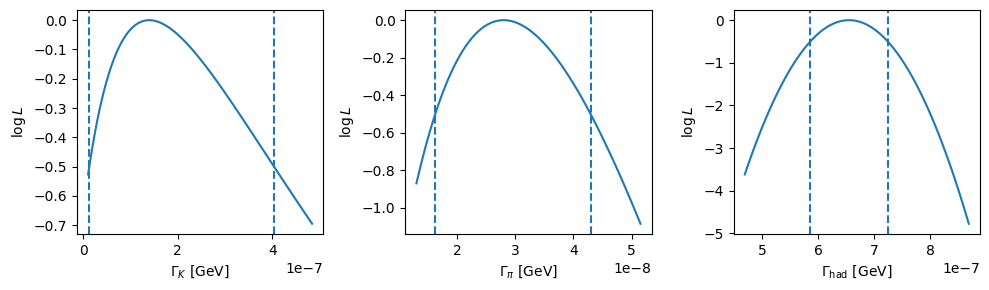

In [24]:
fig,axis=plt.subplots(1,3,figsize=(10,3))
for i,(upper,lower,central,x_label) in enumerate(zip([gamma_K_upper_last,gamma_pi_upper_last,gamma_had_upper],[gamma_K_lower_last,gamma_pi_lower_last,gamma_had_lower],[gamma_K_central_last,gamma_pi_central_last,gamma_had_central],[r'$\Gamma_K$ [GeV]',r'$\Gamma_\pi$ [GeV]',r'$\Gamma_\mathrm{had}$ [GeV]'])):
    x=np.linspace(lower*0.8,upper*1.2,100)
    axis[i].plot(x,logL_model(x,central,upper,lower))
    axis[i].axvline(lower,linestyle='--',label='lower boundary')
    axis[i].axvline(upper,linestyle='--',label='upper boundary')
    axis[i].set_xlabel(x_label)
    axis[i].set_ylabel(r'$\log L$')
plt.tight_layout()
plt.savefig('/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/nlls.pdf')

# fit with iminuit

## suppression_mode: spin

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.729e-08                  │              Nfcn = 308              │
│ EDM = 1.73e-08 (Goal: 0.0001)    │            time = 9.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ws        │    1.0    │    2.1    │    -1.0    │    2.2     │    0    │   10    │       │
│ 1 │ wv        │   0.09    │   0.23    │   -0.09    │    0.39    │    0    │    1    │       │
│ 2 │ gamma_fac │   1.00    │   0.11    │   -0.11    │    0.11    │    0    │   10    │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          ws           │          wv           │       gamma_fac       │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -1.0    │    2.2    │   -0.09   │   0.39    │   -0.11   │   0.11    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   True    │   False   │   True    │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────────┬───────────────────────────────┐
│           │        ws        wv gamma_fac │
├───────────┼───────────────────────────────┤
│        ws │      5.34     -0.60     0.001 │
│        wv │     -0.60    0.0757     0.002 │
│ gamma_fac │     0.001     0.002    0.0112 │
└───────────┴───────────────────────────────┘

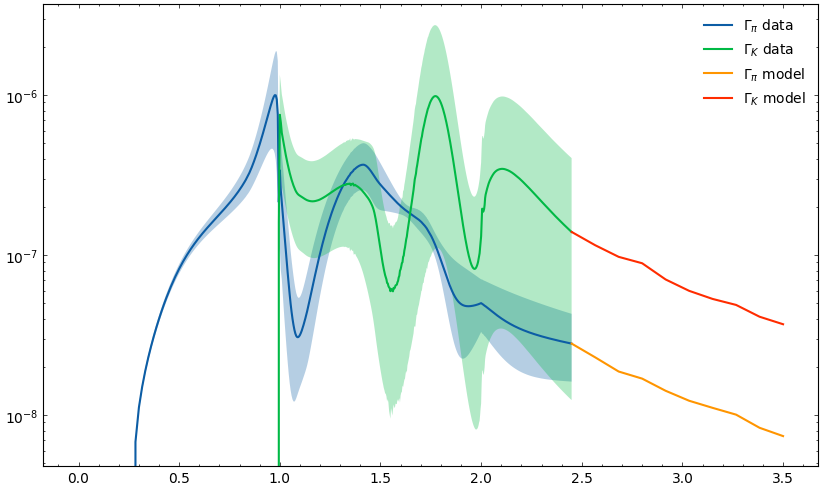

In [7]:
from scalarhadronizer import ScalarHadronizer

from iminuit import Minuit
m_fit=2450
SH_fit=ScalarHadronizer(scalar_mass=m_fit,suppression_mode='spin')
meson_list=SH_fit.initialize_meson_list_for_parameter_fits()

def nll_minuit(ws,wv,gamma_fac):
    br_pi,br_K,gamma_pi,gamma_K=SH_fit.parameter_fit_func(ws,wv,gamma_fac,meson_list)
    return -logL_model(gamma_pi,gamma_pi_central_last,gamma_pi_upper_last,gamma_pi_lower_last)-logL_model(gamma_K,gamma_K_central_last,gamma_K_upper_last,gamma_K_lower_last)-logL_model(gamma_fac,1,gamma_had_upper/gamma_had_central,gamma_had_lower/gamma_had_central)

m = Minuit(nll_minuit, ws=1,wv=0.5,gamma_fac=1)
m.limits=[(0,10),(0,1),(0,10)]
m.errordef = Minuit.LIKELIHOOD
m.migrad()
m.hesse()
SH_fit.set_parameters(strange_weight=m.params[0].value,spin_suppression=m.params[1].value,gamma_fac=m.params[2].value,up_weight=1,down_weight=1,charm_weight=0,bottom_weight=0)
display(m.minos())

ws_opt=m.params[0].value
wv_opt=m.params[1].value
gamma_fac_opt=m.params[2].value
cov_matrix=np.array(m.covariance)

m_list=np.linspace(m_fit*1e-3,3.5,10)
pi_list=[]
K_list=[]
for mass in m_list:
    SH=ScalarHadronizer(scalar_mass=mass*1e3,strange_weight=ws_opt,spin_suppression=wv_opt,suppression_mode='spin',gamma_fac=gamma_fac_opt)
    meson_list2=SH.initialize_meson_list_for_parameter_fits()
    br_pi,br_K,gamma_pi,gamma_K=SH.parameter_fit_func(ws_opt,wv_opt,gamma_fac_opt,meson_list2)
    pi_list.append(gamma_pi)
    K_list.append(gamma_K)
    

fig,ax=plt.subplots(figsize=(10,6))
ax.plot(pi_data[:,0],pi_data[:,1],label=r'$\Gamma_\pi$ data')
ax.fill_between(pi_data[:,0], pi_data[:,2],pi_data[:,3],alpha=0.3,interpolate=True)
ax.plot(K_data[:,0],K_data[:,1],label=r'$\Gamma_K$ data')
ax.fill_between(K_data[:,0], K_data[:,2],K_data[:,3],alpha=0.3,interpolate=True)

ax.plot(m_list,pi_list,label=r'$\Gamma_\pi$ model')
ax.plot(m_list,K_list,label=r'$\Gamma_K$ model')
ax.set_yscale('log')
plt.legend()


In [31]:
def write_result_to_file(result_dict):
    with open('/home/henry/Documents/Uni/Masterarbeit/latex-thesis/fitdata.dat', 'w') as file:
        for key, value in result_dict.items():
            precision=3
            rounded_val=np.round(value,precision)
            file.write(f"{key},{value}\n")

In [32]:
results_dict['ws']=ws_opt
results_dict['av']=wv_opt
results_dict['a_gamma']=gamma_fac_opt

ws_upper=m.merrors['ws'].upper
wv_upper=m.merrors['wv'].upper
gamma_fac_upper=m.merrors['gamma_fac'].upper
gamma_fac_lower=abs(m.merrors['gamma_fac'].lower)

results_dict['ws_upper']=ws_upper
results_dict['av_upper']=wv_upper
results_dict['a_gamma_upper']=gamma_fac_upper
results_dict['a_gamma_lower']=gamma_fac_lower
for i in [1,2,3]:
    for j in [1,2,3]:
        name='c'+str(i)+str(j)
        results_dict[name]=cov_matrix[i-1,j-1]

write_result_to_file(results_dict)

### likelihood contours

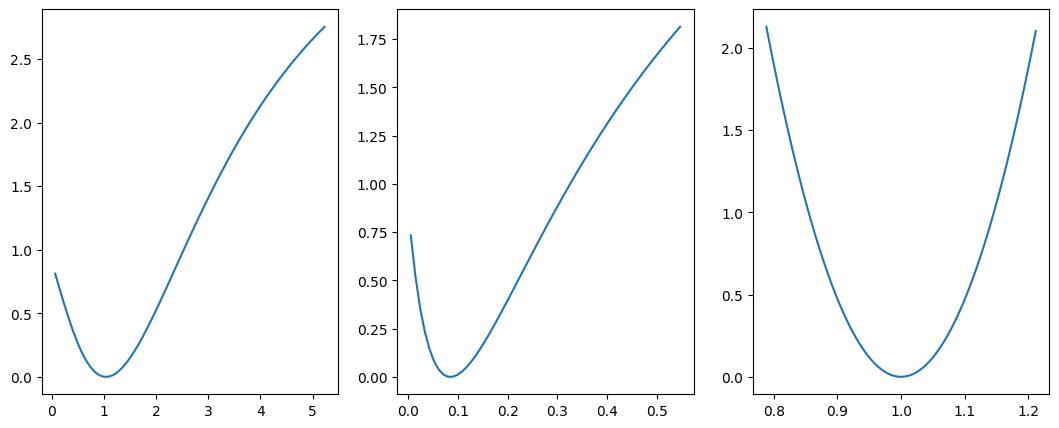

In [28]:
#likelihood profiles
fig,axis=plt.subplots(1,3,figsize=(13,5))
for i,a in enumerate(['ws','wv','gamma_fac']):
    x,y=m.profile(a)
    axis[i].plot(x[x>0],y[x>0])

(array([-8.45169009e-01, -7.39003179e-01, -6.32837350e-01, -5.26671520e-01,
        -4.20505690e-01, -3.14339860e-01, -2.08174031e-01, -1.02008201e-01,
         4.15762891e-03,  1.10323459e-01,  2.16489288e-01,  3.22655118e-01,
         4.28820948e-01,  5.34986778e-01,  6.41152607e-01,  7.47318437e-01,
         8.53484267e-01,  9.59650097e-01,  1.06581593e+00,  1.17198176e+00,
         1.27814759e+00,  1.38431342e+00,  1.49047925e+00,  1.59664508e+00,
         1.70281090e+00,  1.80897673e+00,  1.91514256e+00,  2.02130839e+00,
         2.12747422e+00,  2.23364005e+00,  2.33980588e+00,  2.44597171e+00,
         2.55213754e+00,  2.65830337e+00,  2.76446920e+00,  2.87063503e+00,
         2.97680086e+00,  3.08296669e+00,  3.18913252e+00,  3.29529835e+00,
         3.40146418e+00,  3.50763001e+00,  3.61379584e+00,  3.71996167e+00,
         3.82612750e+00,  3.93229333e+00,  4.03845916e+00,  4.14462499e+00,
         4.25079082e+00,  4.35695665e+00]),
 array([-1.87219825, -1.79577883, -1.7193594

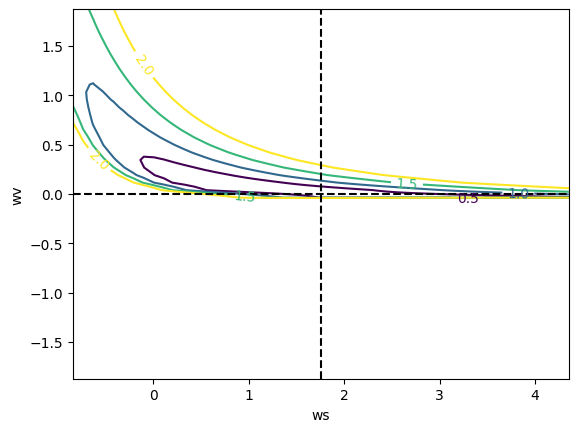

In [48]:
m.draw_contour('ws','wv')

In [36]:
def get_contour(contour_name,par1,par2,cl=0.68):
    file_path=f'pkls_for_plots/{contour_name}.pkl'
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            contour = pickle.load(f)
    else:
        contour=m.mncontour(par1,par2,interpolated=400,cl=cl)
        with open(file_path,'wb') as f:
            pickle.dump(contour,f)
    return contour

In [ ]:
contour_wswv=get_contour('contour_wswv','ws','wv')
plt.plot(contour_wswv[:,0],contour_wswv[:,1])

In [8]:
file_path='pkls_for_plots/contour_wswv_experimental.pkl'
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        contour_wswv_experimental = pickle.load(f)
else:
    contour_wswv_experimental=m.mncontour('ws','wv',experimental=True)
    with open(file_path,'wb') as f:
        pickle.dump(contour_wswv_experimental,f)

In [9]:
file_path='pkls_for_plots/contour_wsgamma_experimental.pkl'
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        contour_wsgamma_experimental = pickle.load(f)
else:
    contour_wsgamma_experimental=m.mncontour('ws','gamma_fac',experimental=True)
    with open(file_path,'wb') as f:
        pickle.dump(contour_wsgamma_experimental,f)

In [10]:
file_path='pkls_for_plots/contour_wvgamma_experimental.pkl'
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        contour_wvgamma_experimental = pickle.load(f)
else:
    contour_wvgamma_experimental=m.mncontour('wv','gamma_fac',experimental=True)
    with open(file_path,'wb') as f:
        pickle.dump(contour_wvgamma_experimental,f)

In [69]:
contour_wvgamma=get_contour('contour_wvgamma','wv','gamma_fac')

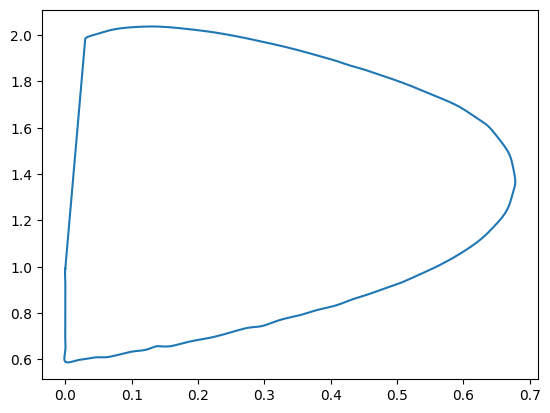

In [72]:
#fix wvgamma contour
cutoff=308
plt.plot(np.append(contour_wvgamma[:cutoff,0],contour_wvgamma[-1,0]),np.append(contour_wvgamma[:cutoff,1],contour_wvgamma[-1,1]))

In [74]:
contour_wswv30=get_contour('contour_wswv30','ws','wv',cl=0.3)
contour_wswv50=get_contour('contour_wswv50','ws','wv',cl=0.5)

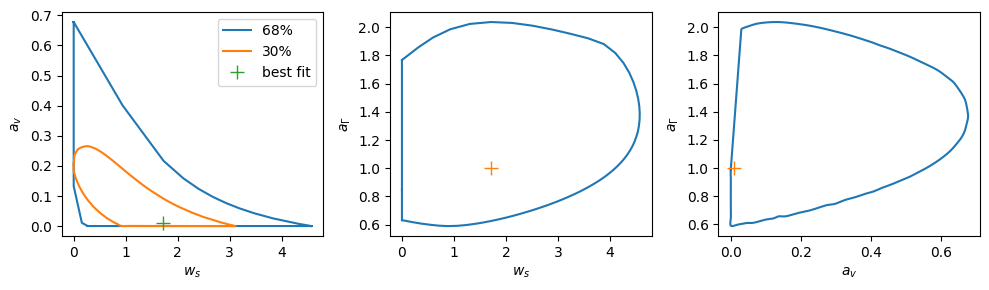

In [77]:
fig,axis=plt.subplots(1,3,figsize=(10,3))
axis[0].plot(contour_wswv_experimental[:,0],contour_wswv_experimental[:,1],label='68%')
axis[0].plot(contour_wswv30[:,0],contour_wswv30[:,1],label='30%')
#axis[0].plot(contour_wswv50[:,0],contour_wswv50[:,1])
axis[0].plot(ws_opt,wv_opt,'+',markersize=10,label='best fit')
axis[0].set_xlabel(r'$w_s$')
axis[0].set_ylabel(r'$a_v$')
axis[1].plot(contour_wsgamma_experimental[:,0],contour_wsgamma_experimental[:,1])
axis[1].plot(ws_opt,gamma_fac_opt,'+',markersize=10)
axis[1].set_xlabel(r'$w_s$')
axis[1].set_ylabel(r'$a_{\Gamma}$')
#axis[2].plot(contour_wvgamma_experimental[:,0],contour_wvgamma_experimental[:,1])
axis[2].plot(np.append(contour_wvgamma[:cutoff,0],contour_wvgamma[-1,0]),np.append(contour_wvgamma[:cutoff,1],contour_wvgamma[-1,1]))
axis[2].plot(wv_opt,gamma_fac_opt,'+',markersize=10)
axis[2].set_xlabel(r'$a_v$')
axis[2].set_ylabel(r'$a_{\Gamma}$')
axis[0].legend()
plt.tight_layout()
plt.savefig('/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/likelihood_contours.pdf')

### result of best fit model

In [9]:
SH_best_fit=ScalarHadronizer(scalar_mass=m_fit,strange_weight=ws_opt,spin_suppression=wv_opt,gamma_fac=gamma_fac_opt)
SH_best_fit.simulateDecay()

Generated 47 initial meson pairs.


In [65]:
SH_best_fit.print_initial_states()
SH_best_fit.print_final_states(10)

The following initial states were generated:
K-[-321] K+[321]: 0.10661372892347296
K~0[-311] K0[311]: 0.10644820868552186
omega(782)[223] h(1)(1415)[10333]: 0.06788449559988141
K*(892)-[-323] K*(892)+[323]: 0.062223241955098194
K*(892)~0[-313] K*(892)0[313]: 0.06191670991059513
eta'(958)[331] eta'(958)[331]: 0.05364839088329415
omega(782)[223] omega(782)[223]: 0.051566528966569325
pi-[-211] pi+[211]: 0.03418595873157222
f(0)(980)[9010221] f(0)(980)[9010221]: 0.03070618208391348
f(0)(1370)[10221] f(0)(980)[9010221]: 0.030558310712063254
eta[221] eta'(958)[331]: 0.02919280567310415
eta[221] eta(1295)[100221]: 0.027746935538042073
eta[221] eta(1405)[9020221]: 0.024893181157691412
eta'(958)[331] eta(1475)[100331]: 0.02264393388674962
rho(770)-[-213] rho(770)+[213]: 0.02075661558813831
a(0)(980)-[-9000211] a(0)(980)+[9000211]: 0.020646017880029267
omega(782)[223] phi(1020)[333]: 0.019715310713552994
eta[221] eta[221]: 0.01922098031602393
eta[221] eta(1475)[100331]: 0.018952571445412143
f(2)

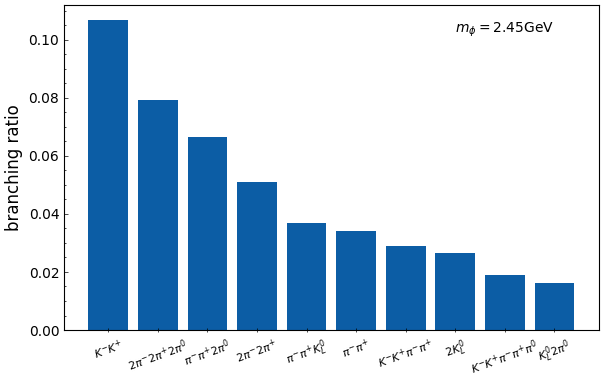

In [10]:
fig,ax=SH_best_fit.plot_final_state_hist(show=False)
ax.tick_params(axis='x', which='minor', bottom=False, top=False)
ax.tick_params(axis='x', which='major', direction='inout',top=False)
ax.tick_params(axis='y', which='both', right=False)
ax.set_ylabel('branching ratio')
plt.savefig('/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/final_state_hist1.pdf')


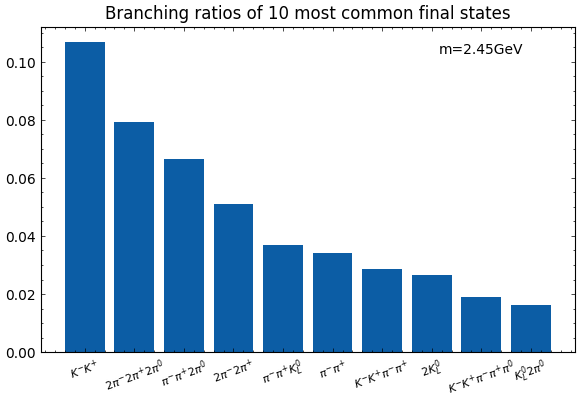

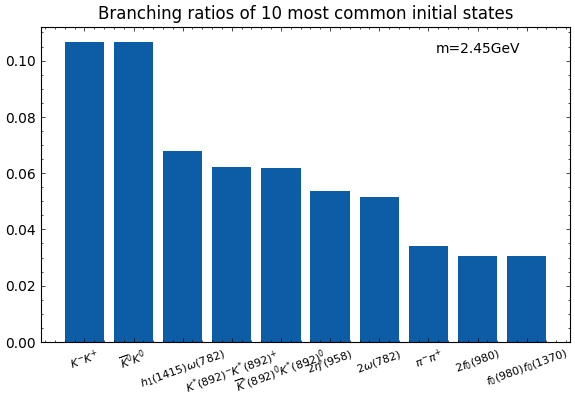

In [ ]:
SH_best_fit.plot_initial_state_hist(n=10)

Generated 125 initial meson pairs.


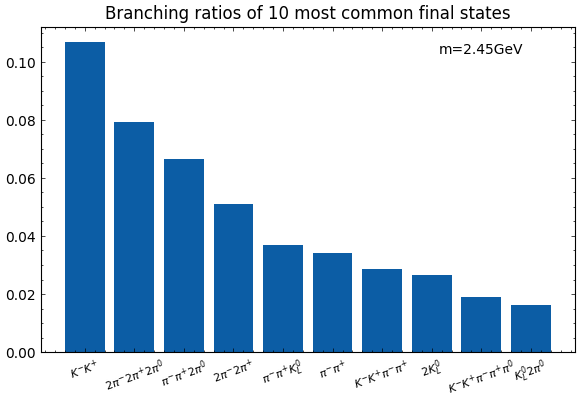

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Branching ratios of 10 most common final states'}>)

In [87]:
SH_best_fit2=ScalarHadronizer(scalar_mass=3000,strange_weight=ws_opt,spin_suppression=wv_opt,gamma_fac=gamma_fac_opt)
SH_best_fit2.simulateDecay()
SH_best_fit.plot_final_state_hist()

### error from monte carlo method

In [30]:
import networkx as nx

def sample_positive_multivariate_normal(mean, cov, size=1):
    samples = []
    while len(samples) < size:
        sample = np.random.multivariate_normal(mean, cov)
        if np.all(sample > 0):
            samples.append(sample)
    return np.array(samples)

def compute_errors(m,ws_opt,wv_opt,gamma_fac_opt,cov_matrix):
    sampled_pars = sample_positive_multivariate_normal([ws_opt, wv_opt, gamma_fac_opt], cov_matrix, 100)
    SH_sampled = ScalarHadronizer(scalar_mass=m)
    decay_graph_init, _ = SH_sampled.build_decay_graph(exclude_below_threshold=False)
    fs_keys = [s for s, d in decay_graph_init.out_degree() if d == 0]
    
    final_state_samples = {key: [[], []] for key in fs_keys}
    final_state_samples.update({'total': [], 'pi': [[], []], 'K': [[], []]})
    
    for ws_sample, wv_sample, gamma_sample in sampled_pars:
        SH_sampled.set_parameters(spin_suppression=wv_sample,strange_weight= ws_sample, gamma_fac=gamma_sample)
        new_initial_states = SH_sampled.make_initialMesonPairs(exclude_below_threshold=False)
        reweighted_graph = SH_sampled.buildWeights(decay_graph_init, new_initial_states, fs_keys)
        attributes = nx.get_node_attributes(reweighted_graph, 'weight')
        gam_tot = SH_sampled.get_decay_width(1) 
        
        for key in fs_keys:
            final_state_samples[key][0].append(attributes[key])
            final_state_samples[key][1].append(SH_sampled.get_decay_width(attributes[key]))
        
        final_state_samples['total'].append(gam_tot)
        final_state_samples['pi'][0].append(attributes[(-211, 211)] + attributes[(111, 111)])
        final_state_samples['pi'][1].append(SH_sampled.get_decay_width(attributes[(-211, 211)] + attributes[(111, 111)]))
        final_state_samples['K'][0].append(attributes[(-321, 321)] + attributes[(-311, 311)])
        final_state_samples['K'][1].append(SH_sampled.get_decay_width(attributes[(-321, 321)] + attributes[(-311, 311)]))
    
    fs_mean_std = {s: {'BR mean': np.mean(v[0]), 'BR std': np.std(v[0]), 'gamma mean': np.mean(v[1]), 'gamma std': np.std(v[1])} for s, v in final_state_samples.items()}
    
    SH_sampled.set_parameters(spin_suppression=wv_opt,strange_weight=ws_opt,gamma_fac=gamma_fac_opt)
    new_initial_states = SH_sampled.make_initialMesonPairs(exclude_below_threshold=False)
    reweighted_graph = SH_sampled.buildWeights(decay_graph_init, new_initial_states, fs_keys)
    attributes = nx.get_node_attributes(reweighted_graph, 'weight')
    
    for key in fs_keys:
        fs_mean_std[key]['BR central'] = attributes[key]
    
    fs_mean_std['pi']['BR central'] = attributes[(-211, 211)] + attributes[(111, 111)]
    fs_mean_std['K']['BR central'] = attributes[(-321, 321)] + attributes[(-311, 311)]
    
    return fs_mean_std, decay_graph_init

In [45]:
#test bias
SH=ScalarHadronizer(2000,strange_weight=ws_opt,spin_suppression=wv_opt,supression_mode='spin',gamma_fac=gamma_fac_opt)
decay_graph=SH.simulateDecay()
final_states=SH.get_final_states(decay_graph)
fs_mean_and_errors,_=compute_errors(2000)
err=np.zeros(len(final_states))
for i,key in enumerate(final_states):
    err[i]=1-fs_mean_and_errors[key]['BR mean']/final_states[key]
print(np.mean(err),np.std(err))

Generated 14 initial meson pairs.
Generated 26 initial meson pairs.
-0.1597547444707317 0.49846413735237743


In [61]:
import pickle
import os

m_error_fit=np.linspace(m_fit,3500,10)
file_path = 'pkls_for_plots/brs_with_errors_montecarlo.pkl'
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        all_brs = pickle.load(f)
else:
    all_brs=[]
    for mass in m_error_fit:
        print(mass)
        brs_with_errors,dg=compute_errors(mass,ws_opt,wv_opt,gamma_fac_opt,cov_matrix)
        all_brs.append(brs_with_errors)

    with open(file_path,'wb') as f:
        pickle.dump(all_brs,f)

In [ ]:
#test bias
#err=[v['BR std'] for brs_with_errors in all_brs for k,v in brs_with_errors.items()]
err=[1-v['BR mean']/v['BR central'] for brs_with_errors in all_brs for k,v in brs_with_errors.items() if not k in ['total','pi','K']]

print(np.mean(err),np.std(err))
err

nan nan


/tmp/ipykernel_3641/1196318445.py:3: RuntimeWarning: invalid value encountered in scalar divide
  err=[1-v['BR mean']/v['BR central'] for brs_with_errors in all_brs for k,v in brs_with_errors.items() if not k in ['total','pi','K']]


[np.float64(0.15526059382776902),
 np.float64(-5.642945189573258),
 np.float64(-5.64294518957326),
 np.float64(0.15526059382776902),
 np.float64(0.15526059382776902),
 np.float64(-5.642945189573258),
 np.float64(0.1552605938277689),
 np.float64(0.3639704521529138),
 np.float64(-0.0004360536661871528),
 np.float64(-0.9300994490492944),
 np.float64(-2.4079998388394315),
 np.float64(-0.0634471052999177),
 np.float64(-0.2749348878228579),
 np.float64(0.20232799404832602),
 np.float64(0.20232799404832613),
 np.float64(0.20232799404832624),
 np.float64(0.3364785060638925),
 np.float64(0.17709542775234455),
 np.float64(0.32259994525873004),
 np.float64(0.3261772106426748),
 np.float64(-5.642945189573258),
 np.float64(-5.6429451895732585),
 np.float64(-5.64294518957326),
 np.float64(-5.6429451895732585),
 np.float64(-2.326907662168716),
 np.float64(-2.3269076621687157),
 np.float64(-2.3269076621687157),
 np.float64(-2.3269076621687157),
 np.float64(-5.642945189573257),
 np.float64(-5.642945189

: 

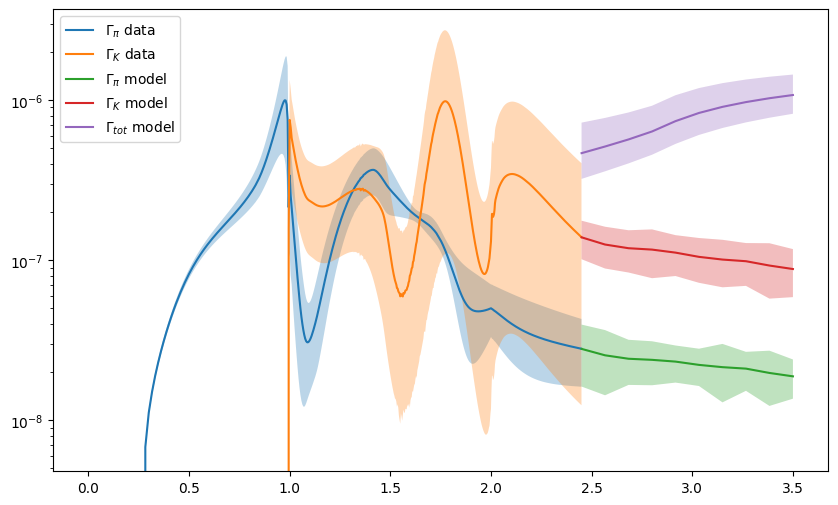

In [64]:
from decay_widths import gg_NNLO,ssbar_NNLO
def plot_decay_widths(m,data):
    fig,ax=plt.subplots(figsize=(10,6))

    gamma_tot=gamma_fac_opt*(gg_NNLO(m,m)+ssbar_NNLO(m,m))

    ax.plot(pi_data[:,0],pi_data[:,1],label=r'$\Gamma_\pi$ data')
    ax.fill_between(pi_data[:,0], pi_data[:,2],pi_data[:,3],alpha=0.3,interpolate=True)
    ax.plot(K_data[:,0],K_data[:,1],label=r'$\Gamma_K$ data')
    ax.fill_between(K_data[:,0], K_data[:,2],K_data[:,3],alpha=0.3,interpolate=True)

    br_pi=np.array([d['pi']['BR central'] for d in data])
    gamma_pi=br_pi*gamma_tot
    br_K=np.array([d['K']['BR central'] for d in data])
    gamma_K=br_K*gamma_tot
    pi_err=np.array([d['pi']['gamma std'] for d in data])
    K_err=np.array([d['K']['gamma std'] for d in data])
    #gamma_tot=np.array([d['total']['gamma mean'] for d in data])
    gamma_err=np.array([d['total']['gamma std'] for d in data])

    ax.plot(m,gamma_pi,label=r'$\Gamma_\pi$ model')
    ax.fill_between(m, gamma_pi-pi_err,gamma_pi+pi_err,alpha=0.3,interpolate=True)
    ax.plot(m,gamma_K,label=r'$\Gamma_K$ model')
    ax.fill_between(m, gamma_K-K_err,gamma_K+K_err,alpha=0.3,interpolate=True)
    ax.plot(m,gamma_tot,label=r'$\Gamma_{tot}$ model')
    #ax.fill_between(m, gamma_tot-gamma_err,gamma_tot+gamma_err,alpha=0.3,interpolate=True)
    ax.fill_between(m, gamma_fac_opt*(gg_NNLO(m,m*2)+ssbar_NNLO(m,m*2)),gamma_fac_opt*(gg_NNLO(m,m/2)+ssbar_NNLO(m,m/2)),alpha=0.3,interpolate=True)

    ax.set_yscale('log')
    ax.legend()
    plt.savefig('/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/pi_K_decay_widths.pdf')

plot_decay_widths(m_error_fit*1e-3,all_brs)

In [21]:
def plot_br_with_error(state,brs,m,label):
    error=np.array([brs[i][state]['BR std'] for i in range(len(m))])
    mean=np.array([brs[i][state]['BR mean'] for i in range(len(m))])
    central=np.array([brs[i][state]['BR central'] for i in range(len(m))])
    #plt.plot(m,mean,label=label)
    plt.plot(m,central,label=label)
    plt.fill_between(m,central+error,central-error,alpha=0.3)
    plt.legend()

In [ ]:
plot_br_with_error((-211,211),all_brs,m_error_fit,label='pi+pi-')
plot_br_with_error((-321,321),all_brs,m_error_fit,label='K+K-')
plot_br_with_error((111,111,111,111),all_brs,m_error_fit,label='4pi0')
plot_br_with_error((-211,111,111,211),all_brs,m_error_fit,label='pi+pi-2pi0')
plot_br_with_error((-211,-211,211,211),all_brs,m_error_fit,label='2pi+2pi-')

### error from varying parameters in minos intervals

In [40]:
parameters_from_minos=[]
upper_lower_errors={'wv':[0,wv_opt+wv_upper],'ws':[0,ws_opt+ws_upper],'gamma_fac':[gamma_fac_opt-gamma_fac_lower,gamma_fac_opt+gamma_fac_upper]}
SH_err=ScalarHadronizer(scalar_mass=2450)
meson_list=SH_err.initialize_meson_list_for_parameter_fits()

def nll_minuit(ws,wv,gamma_fac):
    br_pi,br_K,gamma_pi,gamma_K=SH_err.parameter_fit_func(ws,wv,gamma_fac,meson_list)
    return -logL_model(gamma_pi,gamma_pi_central_last,gamma_pi_upper_last,gamma_pi_lower_last)-logL_model(gamma_K,gamma_K_central_last,gamma_K_upper_last,gamma_K_lower_last)-logL_model(gamma_fac,1,gamma_had_upper/gamma_had_central,gamma_had_lower/gamma_had_central)

for par in ['ws','wv','gamma_fac']:
    for par_val in upper_lower_errors[par]:
        minuit_error = Minuit(nll_minuit, ws=1,wv=0.1,gamma_fac=1)
        minuit_error.limits=[(0,10),(0,1),(0,10)]
        minuit_error.errordef = Minuit.LIKELIHOOD
        minuit_error.fixto(par,par_val)
        minuit_error.migrad()
        parameters_from_minos.append([minuit_error.params['ws'].value,minuit_error.params['wv'].value,minuit_error.params['gamma_fac'].value])

In [49]:
parameters_from_minos

[[0.0, 0.2054718851695372, 1.0012943145768167],
 [3.4000626143315653, 3.911631997623828e-08, 1.254080011477825],
 [1.863989797184079, 0.0, 0.9925393933903066],
 [0.030572949877419178, 0.3499134859803592, 1.1571951296507244],
 [1.1904897360212554, 8.558385761737964e-06, 0.6972789339471643],
 [1.7305922442962427, 0.07275963259644894, 1.5507070489310064]]

In [110]:
import networkx as nx
#error by varying parameters within minos error range
def compute_errors_from_par_variation(mass,par_list,optimal_values=[ws_opt,wv_opt,gamma_fac_opt],suppression_mode='spin'):
    SH_err=ScalarHadronizer(scalar_mass=mass,suppression_mode=suppression_mode)
    meson_list=SH_err.initialize_meson_list_for_parameter_fits()
    decay_graph_init, _ = SH_err.build_decay_graph(exclude_below_threshold=False)
    fs_keys = [s for s, d in decay_graph_init.out_degree() if d == 0]
    states_with_errors_temp={s:{'BR err':[],'gamma err':[]} for s in fs_keys+['pi','K','gamma total']}

    for pars in par_list:
        SH_err.set_parameters(strange_weight=pars[0],spin_suppression=pars[1],gamma_fac=pars[2])
        new_initial_states = SH_err.make_initialMesonPairs(exclude_below_threshold=False)
        reweighted_graph = SH_err.buildWeights(decay_graph_init, new_initial_states, fs_keys)
        branching_ratios = nx.get_node_attributes(reweighted_graph, 'weight')
        gam_tot = SH_err.get_decay_width(1) 
        for state in fs_keys:
            states_with_errors_temp[state]['BR err'].append(branching_ratios[state])
            states_with_errors_temp[state]['gamma err'].append(SH_err.get_decay_width(branching_ratios[state]))
        states_with_errors_temp['pi']['BR err'].append(branching_ratios[(-211,211)]+branching_ratios[(111,111)])
        states_with_errors_temp['K']['BR err'].append(branching_ratios[(-321,321)]+branching_ratios[(-311,311)])
        states_with_errors_temp['pi']['BR err'].append(branching_ratios[(-211,211)]+branching_ratios[(111,111)])
        states_with_errors_temp['pi']['gamma err'].append(SH_err.get_decay_width(branching_ratios[(-211,211)])+SH_err.get_decay_width(branching_ratios[(111,111)]))
        states_with_errors_temp['K']['gamma err'].append(SH_err.get_decay_width(branching_ratios[(-311,311)])+SH_err.get_decay_width(branching_ratios[(-321,321)]))
        states_with_errors_temp['gamma total']['gamma err'].append(SH_err.get_decay_width(1))

    #central values
    SH_err.set_parameters(strange_weight=optimal_values[0],spin_suppression=optimal_values[1],gamma_fac=optimal_values[2])
    new_initial_states = SH_err.make_initialMesonPairs(exclude_below_threshold=False)
    reweighted_graph = SH_err.buildWeights(decay_graph_init, new_initial_states, fs_keys)
    branching_ratios_central = nx.get_node_attributes(reweighted_graph, 'weight')
    gam_tot_central = SH_err.get_decay_width(1) 
    states_with_errors={s:{'BR central':0,'BR upper':0,'BR lower':0, 'gamma central':0,'gamma upper':0, 'gamma lower':0} for s in fs_keys+['pi','K','gamma total']}
    for state,errs in states_with_errors_temp.items():
        if state!='gamma total':
            try: states_with_errors[state]['BR upper']=max(states_with_errors_temp[state]['BR err'])
            except ValueError as e:
                print(state)
                print(states_with_errors_temp[state])
                raise e
            states_with_errors[state]['BR lower']=min(states_with_errors_temp[state]['BR err'])
        states_with_errors[state]['gamma upper']=max(states_with_errors_temp[state]['gamma err'])
        states_with_errors[state]['gamma lower']=min(states_with_errors_temp[state]['gamma err'])
        if state not in ['pi','K','gamma total']:
            states_with_errors[state]['BR central']=branching_ratios_central[state]
            states_with_errors[state]['gamma central']=SH_err.get_decay_width(branching_ratios_central[state])
    states_with_errors['pi']['BR central']=branching_ratios_central[(-211,211)]+branching_ratios_central[(111,111)]
    states_with_errors['K']['BR central']=branching_ratios_central[(-321,321)]+branching_ratios_central[(-311,311)]
    states_with_errors['pi']['gamma central']=SH_err.get_decay_width(branching_ratios_central[(-211,211)])+SH_err.get_decay_width(branching_ratios_central[(111,111)])
    states_with_errors['K']['gamma central']=SH_err.get_decay_width(branching_ratios_central[(-321,321)])+SH_err.get_decay_width(branching_ratios_central[(-311,311)])
    states_with_errors['gamma total']['gamma central']=SH_err.get_decay_width(1)
    return states_with_errors


In [44]:
m_error_fit=np.linspace(m_fit,3700,50)
file_path = 'pkls_for_plots/brs_with_errors_minos.pkl'
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        all_brs = pickle.load(f)
else:
    all_brs=[]
    for mass in m_error_fit:
        print(mass)
        brs_with_errors=compute_errors_from_par_variation(mass,parameters_from_minos)
        all_brs.append(brs_with_errors)

    with open(file_path,'wb') as f:
        pickle.dump(all_brs,f)

2450.0
Generated 49 initial meson pairs.
2475.5102040816328
Generated 56 initial meson pairs.
2501.0204081632655
Generated 57 initial meson pairs.
2526.530612244898
Generated 61 initial meson pairs.
2552.0408163265306
Generated 64 initial meson pairs.
2577.5510204081634
Generated 72 initial meson pairs.
2603.061224489796
Generated 75 initial meson pairs.
2628.5714285714284
Generated 77 initial meson pairs.
2654.081632653061
Generated 80 initial meson pairs.
2679.591836734694
Generated 80 initial meson pairs.
2705.1020408163267
Generated 89 initial meson pairs.
2730.612244897959
Generated 92 initial meson pairs.
2756.122448979592
Generated 92 initial meson pairs.
2781.6326530612246
Generated 95 initial meson pairs.
2807.1428571428573
Generated 101 initial meson pairs.
2832.6530612244896
Generated 107 initial meson pairs.
2858.1632653061224
Generated 115 initial meson pairs.
2883.673469387755
Generated 124 initial meson pairs.
2909.183673469388
Generated 130 initial meson pairs.
2934.693

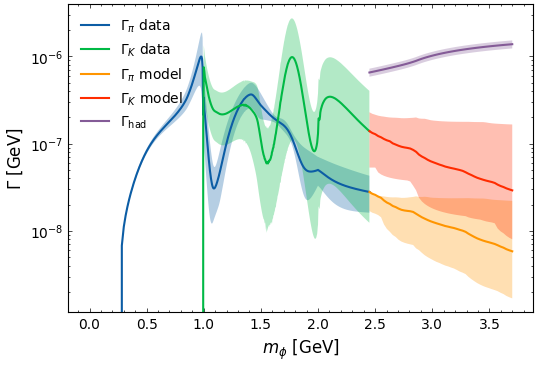

In [108]:
from decay_widths import gamma_gg,gamma_ss

def plot_errors_from_par_variation(plot_mass,data,path):
    fig,ax=plt.subplots()
    gamma_had=gamma_fac_opt*(gamma_gg(plot_mass)+gamma_ss(plot_mass))

    ax.plot(pi_data[:,0],pi_data[:,1],label=r'$\Gamma_\pi$ data')
    ax.fill_between(pi_data[:,0], pi_data[:,2],pi_data[:,3],alpha=0.3,interpolate=True)
    ax.plot(K_data[:,0],K_data[:,1],label=r'$\Gamma_K$ data')
    ax.fill_between(K_data[:,0], K_data[:,2],K_data[:,3],alpha=0.3,interpolate=True)

    br_pi=np.array([d['pi']['BR central'] for d in data])
    gamma_pi=np.array([d['pi']['gamma central'] for d in data])
    br_K=np.array([d['K']['BR central'] for d in data])
    gamma_K=np.array([d['K']['gamma central'] for d in data])
    pi_upper=np.array([d['pi']['gamma upper'] for d in data])
    pi_lower=np.array([d['pi']['gamma lower'] for d in data])
    K_upper=np.array([d['K']['gamma upper'] for d in data])
    K_lower=np.array([d['K']['gamma lower'] for d in data])
    gamma_upper=np.array([d['gamma total']['gamma upper'] for d in data])
    gamma_lower=np.array([d['gamma total']['gamma lower'] for d in data])

    ax.plot(plot_mass,gamma_pi,label=r'$\Gamma_\pi$ model')
    ax.fill_between(plot_mass, pi_lower,pi_upper,alpha=0.3,interpolate=True)
    ax.plot(plot_mass,gamma_K,label=r'$\Gamma_K$ model')
    ax.fill_between(plot_mass, K_lower,K_upper,alpha=0.3,interpolate=True)
    ax.plot(plot_mass,gamma_had,label=r'$\Gamma_\text{had}$')
    ax.fill_between(plot_mass, gamma_lower,gamma_upper,alpha=0.3,interpolate=True)
    #ax.fill_between(plot_mass, gamma_fac_opt*(gg_NNLO(plot_mass,plot_mass*2)+ssbar_NNLO(plot_mass,plot_mass*2)),gamma_fac_opt*(gg_NNLO(plot_mass,plot_mass/2)+ssbar_NNLO(plot_mass,plot_mass/2)),alpha=0.3,interpolate=True)

    ax.set_yscale('log')
    ax.set_xlabel(r'$m_\phi$ [GeV]')
    ax.set_ylabel(r'$\Gamma$ [GeV]')
    ax.legend(loc='upper left')
    plt.savefig(path)

plot_errors_from_par_variation(m_error_fit*1e-3,all_brs,path='/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/pi_K_decay_widths_with_minos_error.pdf')

In [85]:
from decay_widths import gamma_hadrons,gamma_total
def plot_br_with_minos_error(axis,state,brs,m,label):
    m=m*1e-3
    hadronic_br=gamma_hadrons(m)/gamma_total(m)
    upper=np.array([brs[i][state]['BR upper'] for i in range(len(m))])*hadronic_br
    lower=np.array([brs[i][state]['BR lower'] for i in range(len(m))])*hadronic_br
    central=np.array([brs[i][state]['BR central'] for i in range(len(m))])*hadronic_br
    axis.plot(m,central,label=label)
    axis.fill_between(m,upper,lower,alpha=0.3)
    axis.legend()
    axis.set_xlabel(r'$m_\phi$ [GeV]')
    axis.set_ylabel('branching ratio')

/home/henry/Documents/Uni/Masterarbeit/code/owndecayer/decay_widths.py:174: RuntimeWarning: invalid value encountered in sqrt
  def beta(x):


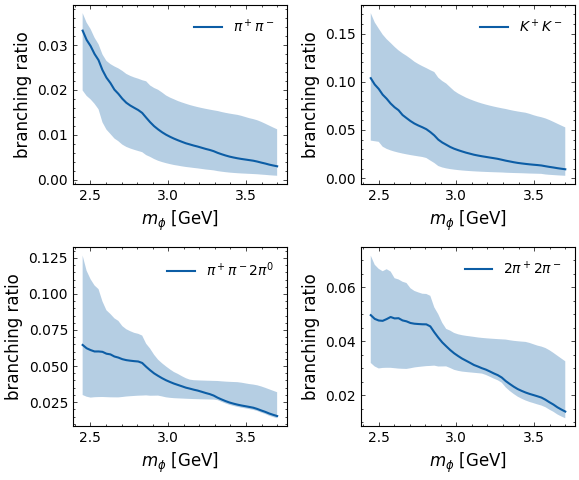

In [90]:
fig,ax=plt.subplots(2,2,figsize=(6,5))
plot_br_with_minos_error(ax[0,0],(-211,211),all_brs,m_error_fit,label=r'$\pi^+\pi^-$')
plot_br_with_minos_error(ax[0,1],(-321,321),all_brs,m_error_fit,label=r'$K^+K^-$')
plot_br_with_minos_error(ax[1,0],(-211,111,111,211),all_brs,m_error_fit,label=r'$\pi^+\pi^-2\pi^0$')
plot_br_with_minos_error(ax[1,1],(-211,-211,211,211),all_brs,m_error_fit,label=r'$2\pi^+2\pi^-$')
plt.tight_layout()
plt.savefig('/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/brs_with_error.pdf')

### version 2
set all parameters to minos boundary values at the same time, using all combinations of boundaries. Instead of setting one parameter to boundary and the others to optimum

In [49]:
parameters_from_minos2=[(ws_opt+ws_upper,wv_opt+wv_upper,gamma_fac_opt+gamma_fac_upper),
                        (ws_opt+ws_upper,wv_opt+wv_upper,gamma_fac_opt-gamma_fac_lower),
                        (ws_opt+ws_upper,0,gamma_fac_opt+gamma_fac_upper),
                        (ws_opt+ws_upper,0,gamma_fac_opt-gamma_fac_lower),
                        (0,wv_opt+wv_upper,gamma_fac_opt+gamma_fac_upper),
                        (0,wv_opt+wv_upper,gamma_fac_opt-gamma_fac_lower),
                        (0,0,gamma_fac_opt+gamma_fac_upper),
                        (0,0,gamma_fac_opt-gamma_fac_lower)]

In [55]:
m_error_fit=np.linspace(m_fit,3500,10)
file_path = 'pkls_for_plots/brs_with_errors_minos2.pkl'
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        all_brs = pickle.load(f)
else:
    all_brs=[]
    for mass in m_error_fit:
        print(mass)
        brs_with_errors=compute_errors_from_par_variation(mass,parameters_from_minos2)
        all_brs.append(brs_with_errors)

    with open(file_path,'wb') as f:
        pickle.dump(all_brs,f)

2450.0
Generated 49 initial meson pairs.
2566.6666666666665
Generated 68 initial meson pairs.
2683.3333333333335
Generated 80 initial meson pairs.
2800.0
Generated 99 initial meson pairs.
2916.6666666666665
Generated 131 initial meson pairs.
3033.3333333333335
Generated 155 initial meson pairs.
3150.0
Generated 178 initial meson pairs.
3266.666666666667
Generated 191 initial meson pairs.
3383.3333333333335
Generated 231 initial meson pairs.
3500.0
Generated 251 initial meson pairs.


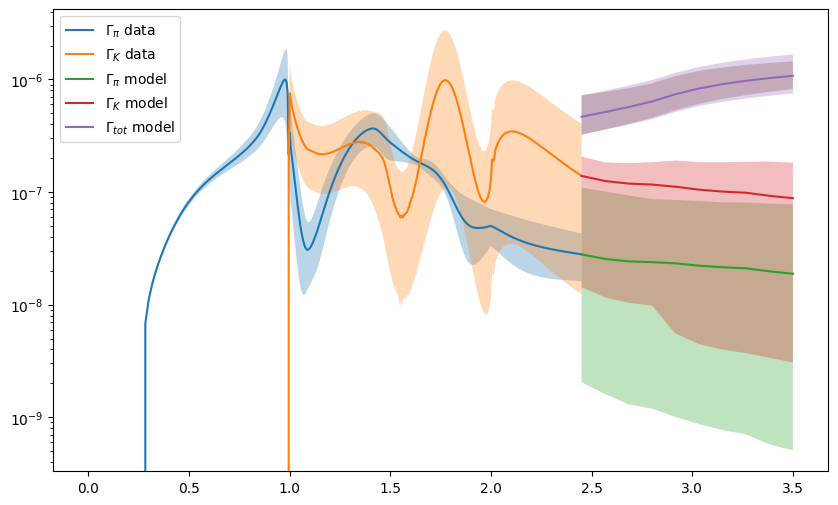

In [58]:
plot_errors_from_par_variation(m_error_fit*1e-3,all_brs,path='/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/pi_K_decay_widths_with_minos_error2.pdf')

## suppression_mode: OAM

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.1111                     │              Nfcn = 269              │
│ EDM = 8.04e-05 (Goal: 0.0001)    │           time = 143.5 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ws        │   0.23    │   0.70    │   -0.23    │    0.75    │    0    │   10    │       │
│ 1 │ wv        │  1.8e-6   │861395.6e-6│  -1.8e-6   │372609.7e-6 │    0    │    1    │       │
│ 2 │ gamma_fac │   1.00    │   0.11    │   -0.10    │    0.11    │    0    │   10    │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          ws           │          wv           │       gamma_fac       │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.23   │   0.75    │  -1.8e-6  │372609.7e-6│   -0.10   │   0.11    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   True    │   False   │   True    │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────────┬───────────────────────────────┐
│           │        ws        wv gamma_fac │
├───────────┼───────────────────────────────┤
│        ws │     0.529    -25e-6     0.016 │
│        wv │    -25e-6  7.34e-06      0e-6 │
│ gamma_fac │     0.016      0e-6    0.0111 │
└───────────┴───────────────────────────────┘

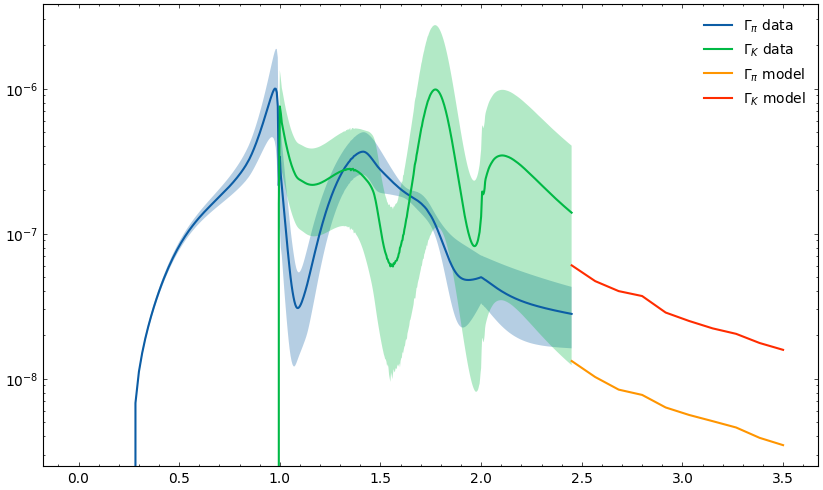

In [101]:
from scalarhadronizer import ScalarHadronizer

from iminuit import Minuit
m_fit=2450
SH_fit=ScalarHadronizer(scalar_mass=m_fit,suppression_mode='OAM')
meson_list=SH_fit.initialize_meson_list_for_parameter_fits()

def nll_minuit(ws,wv,gamma_fac):
    br_pi,br_K,gamma_pi,gamma_K=SH_fit.parameter_fit_func(ws,wv,gamma_fac,meson_list)
    return -logL_model(gamma_pi,gamma_pi_central_last,gamma_pi_upper_last,gamma_pi_lower_last)-logL_model(gamma_K,gamma_K_central_last,gamma_K_upper_last,gamma_K_lower_last)-logL_model(gamma_fac,1,gamma_had_upper/gamma_had_central,gamma_had_lower/gamma_had_central)

m = Minuit(nll_minuit, ws=1,wv=0.5,gamma_fac=1)
m.limits=[(0,10),(0,1),(0,10)]
m.errordef = Minuit.LIKELIHOOD
m.migrad()
m.hesse()
SH_fit.set_parameters(strange_weight=m.params[0].value,spin_suppression=m.params[1].value,gamma_fac=m.params[2].value,up_weight=1,down_weight=1,charm_weight=0,bottom_weight=0)
display(m.minos())

ws_opt_oam=m.params[0].value
wv_opt_oam=m.params[1].value
gamma_fac_opt_oam=m.params[2].value
cov_matrix_oam=np.array(m.covariance)

m_list=np.linspace(m_fit*1e-3,3.5,10)
pi_list=[]
K_list=[]
for mass in m_list:
    SH=ScalarHadronizer(scalar_mass=mass*1e3,strange_weight=ws_opt,spin_suppression=wv_opt,suppression_mode='OAM',gamma_fac=gamma_fac_opt)
    meson_list2=SH.initialize_meson_list_for_parameter_fits()
    br_pi,br_K,gamma_pi,gamma_K=SH.parameter_fit_func(ws_opt,wv_opt,gamma_fac_opt,meson_list2)
    pi_list.append(gamma_pi)
    K_list.append(gamma_K)
    

fig,ax=plt.subplots(figsize=(10,6))
ax.plot(pi_data[:,0],pi_data[:,1],label=r'$\Gamma_\pi$ data')
ax.fill_between(pi_data[:,0], pi_data[:,2],pi_data[:,3],alpha=0.3,interpolate=True)
ax.plot(K_data[:,0],K_data[:,1],label=r'$\Gamma_K$ data')
ax.fill_between(K_data[:,0], K_data[:,2],K_data[:,3],alpha=0.3,interpolate=True)

ax.plot(m_list,pi_list,label=r'$\Gamma_\pi$ model')
ax.plot(m_list,K_list,label=r'$\Gamma_K$ model')
ax.set_yscale('log')
plt.legend()


In [103]:
ws_upper_oam=m.merrors['ws'].upper
wv_upper_oam=m.merrors['wv'].upper
gamma_fac_upper_oam=m.merrors['gamma_fac'].upper
gamma_fac_lower_oam=abs(m.merrors['gamma_fac'].lower)

In [104]:
parameters_from_minos_oam=[]
upper_lower_errors={'wv':[0,wv_opt_oam+wv_upper_oam],'ws':[0,ws_opt_oam+ws_upper_oam],'gamma_fac':[gamma_fac_opt_oam-gamma_fac_lower_oam,gamma_fac_opt_oam+gamma_fac_upper_oam]}
SH_err=ScalarHadronizer(scalar_mass=2450)
meson_list=SH_err.initialize_meson_list_for_parameter_fits()

def nll_minuit(ws,wv,gamma_fac):
    br_pi,br_K,gamma_pi,gamma_K=SH_err.parameter_fit_func(ws,wv,gamma_fac,meson_list)
    return -logL_model(gamma_pi,gamma_pi_central_last,gamma_pi_upper_last,gamma_pi_lower_last)-logL_model(gamma_K,gamma_K_central_last,gamma_K_upper_last,gamma_K_lower_last)-logL_model(gamma_fac,1,gamma_had_upper/gamma_had_central,gamma_had_lower/gamma_had_central)

for par in ['ws','wv','gamma_fac']:
    for par_val in upper_lower_errors[par]:
        minuit_error = Minuit(nll_minuit, ws=1,wv=0.1,gamma_fac=1)
        minuit_error.limits=[(0,10),(0,1),(0,10)]
        minuit_error.errordef = Minuit.LIKELIHOOD
        minuit_error.fixto(par,par_val)
        minuit_error.migrad()
        parameters_from_minos_oam.append([minuit_error.params['ws'].value,minuit_error.params['wv'].value,minuit_error.params['gamma_fac'].value])

In [105]:
parameters_from_minos_oam

[[0.0, 0.23925611172170444, 0.9997932359047892],
 [0.9764072297938056, 0.09170245240794782, 0.9999895897475342],
 [2.1095298725864464, 0.0, 0.9965044770067778],
 [1.2999263189554218e-07, 0.3726115061774781, 1.012622538147438],
 [1.0126246981620792, 0.0661206466125819, 0.8981279872292391],
 [1.04798778130109, 0.10602692995563814, 1.1088714122499337]]

In [ ]:
m_error_fit=np.linspace(m_fit,3700,50)
file_path = 'pkls_for_plots/brs_with_errors_minos_oam.pkl'
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        all_brs_oam = pickle.load(f)
else:
    all_brs_oam=[]
    for mass in m_error_fit:
        print(mass)
        brs_with_errors=compute_errors_from_par_variation(mass,parameters_from_minos_oam,optimal_values=[ws_opt_oam,wv_opt_oam,gamma_fac_opt_oam],suppression_mode='OAM')
        all_brs_oam.append(brs_with_errors)

    with open(file_path,'wb') as f:
        pickle.dump(all_brs_oam,f)

2450.0
Generated 49 initial meson pairs.
2475.5102040816328
Generated 56 initial meson pairs.
2501.0204081632655
Generated 57 initial meson pairs.
2526.530612244898
Generated 61 initial meson pairs.
2552.0408163265306
Generated 64 initial meson pairs.
2577.5510204081634
Generated 72 initial meson pairs.
2603.061224489796
Generated 75 initial meson pairs.
2628.5714285714284
Generated 77 initial meson pairs.
2654.081632653061
Generated 80 initial meson pairs.
2679.591836734694
Generated 80 initial meson pairs.
2705.1020408163267
Generated 89 initial meson pairs.
2730.612244897959
Generated 92 initial meson pairs.
2756.122448979592
Generated 92 initial meson pairs.
2781.6326530612246
Generated 95 initial meson pairs.
2807.1428571428573
Generated 101 initial meson pairs.
2832.6530612244896
Generated 107 initial meson pairs.
2858.1632653061224
Generated 115 initial meson pairs.
2883.673469387755
Generated 124 initial meson pairs.
2909.183673469388
Generated 130 initial meson pairs.
2934.693

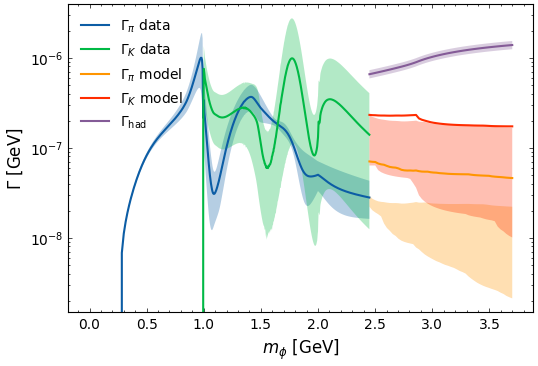

In [109]:
plot_errors_from_par_variation(m_error_fit*1e-3,all_brs_oam,path='/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/pi_K_decay_widths_with_minos_error_oam.pdf')

/home/henry/Documents/Uni/Masterarbeit/code/owndecayer/decay_widths.py:174: RuntimeWarning: invalid value encountered in sqrt
  def beta(x):


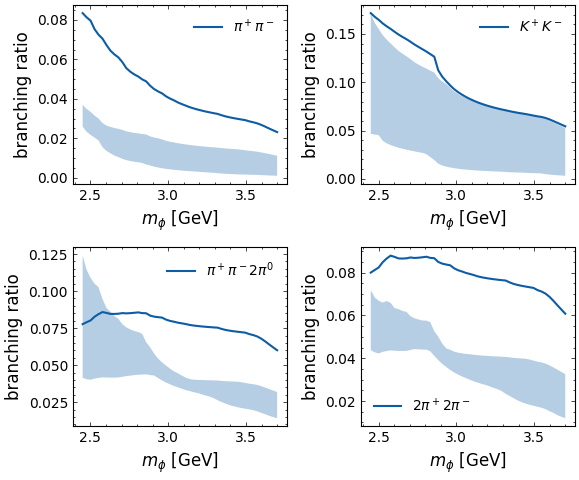

In [111]:
fig,ax=plt.subplots(2,2,figsize=(6,5))
plot_br_with_minos_error(ax[0,0],(-211,211),all_brs_oam,m_error_fit,label=r'$\pi^+\pi^-$')
plot_br_with_minos_error(ax[0,1],(-321,321),all_brs_oam,m_error_fit,label=r'$K^+K^-$')
plot_br_with_minos_error(ax[1,0],(-211,111,111,211),all_brs_oam,m_error_fit,label=r'$\pi^+\pi^-2\pi^0$')
plot_br_with_minos_error(ax[1,1],(-211,-211,211,211),all_brs_oam,m_error_fit,label=r'$2\pi^+2\pi^-$')
plt.tight_layout()
plt.savefig('/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/brs_with_error_oam.pdf')

In [112]:
SH_best_fit=ScalarHadronizer(scalar_mass=m_fit,strange_weight=ws_opt_oam,spin_suppression=wv_opt_oam,gamma_fac=gamma_fac_opt_oam,suppression_mode='OAM')
SH_best_fit.simulateDecay()
fig,ax=SH_best_fit.plot_final_state_hist(show=False)
ax.tick_params(axis='x', which='minor', bottom=False, top=False)
ax.tick_params(axis='x', which='major', direction='inout',top=False)
ax.tick_params(axis='y', which='both', right=False)
ax.set_ylabel('branching ratio')
plt.savefig('/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/final_state_hist_oam.pdf')


TypeError: ScalarHadronizer.__init__() got an unexpected keyword argument 'spin_suppression'

## find largest possible wv consistent with data and plot result

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.5                        │              Nfcn = 192              │
│ EDM = 1.65e-05 (Goal: 0.0001)    │           time = 26.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ws        │   0.022   │   9.248   │   -0.022   │   9.248    │    0    │   10    │       │
│ 1 │ wv        │   0.350   │   0.005   │            │            │    0    │    1    │  yes  │
│ 2 │ gamma_fac │   1.15    │   0.45    │   -0.33    │    0.65    │    0    │   10    │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │          ws           │       gamma_fac       │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.022   │   9.248   │   -0.33   │   0.65    │
│  Valid   │   True    │   False   │   True    │   True    │
│ At Limit │   True    │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌───────────┬───────────────────────────────┐
│           │        ws        wv gamma_fac │
├───────────┼───────────────────────────────┤
│        ws │       1.1       0.0      0.23 │
│        wv │       0.0         0       0.0 │
│ gamma_fac │      0.23       0.0     0.205 │
└───────────┴───────────────────────────────┘

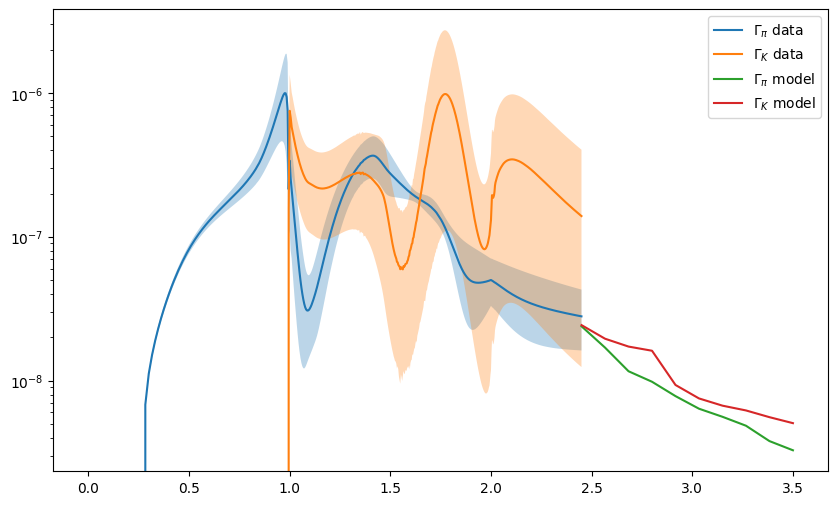

In [ ]:
m_fit=2450
SH_fit=ScalarHadronizer(scalar_mass=m_fit,supression_mode='spin')
meson_list=SH_fit.initialize_meson_list_for_parameter_fits()
def nll_minuit(ws,wv,gamma_fac):
    br_pi,br_K,gamma_pi,gamma_K=SH_fit.parameter_fit_func(ws,wv,gamma_fac,meson_list)
    return -logL_model(gamma_pi,gamma_pi_central_last,gamma_pi_upper_last,gamma_pi_lower_last)-logL_model(gamma_K,gamma_K_central_last,gamma_K_upper_last,gamma_K_lower_last)-logL_model(gamma_fac,1,gg_ss_upper/gg_ss_central,gg_ss_lower/gg_ss_central)

m = Minuit(nll_minuit, ws=1,wv=0.5,gamma_fac=0.8)
m.limits=[(0,10),(0,1),(0,10)]
m.errordef = Minuit.LIKELIHOOD
m.fixto('wv',wv_opt+wv_upper)
m.migrad()
m.hesse()
SH_fit.set_parameters(strange_weight=m.params[0].value,spin_suppression=m.params[1].value,gamma_fac=m.params[2].value,up_weight=1,down_weight=1,charm_weight=0,bottom_weight=0)
display(m.minos())

ws_opt_fixed_wv=m.params[0].value
wv_opt_fixed_wv=m.params[1].value
gamma_fac_opt_fixed_wv=m.params[2].value
cov_matrix2=np.array(m.covariance)

ws_upper_fixed_wv=m.merrors['ws'].upper
gamma_fac_upper_fixed_wv=m.merrors['gamma_fac'].upper
gamma_fac_lower_fixed_wv=abs(m.merrors['gamma_fac'].lower)

m_list=np.linspace(m_fit*1e-3,3.5,10)
pi_list=[]
K_list=[]
for mass in m_list:
    SH=ScalarHadronizer(scalar_mass=mass*1e3,strange_weight=ws_opt_fixed_wv,spin_suppression=wv_opt_fixed_wv,supression_mode='spin',gamma_fac=gamma_fac_opt_fixed_wv)
    meson_list2=SH.initialize_meson_list_for_parameter_fits()
    br_pi,br_K,gamma_pi,gamma_K=SH.parameter_fit_func(ws_opt_fixed_wv,wv_opt_fixed_wv,gamma_fac_opt_fixed_wv,meson_list2)
    pi_list.append(gamma_pi)
    K_list.append(gamma_K)
    

fig,ax=plt.subplots(figsize=(10,6))
ax.plot(pi_data[:,0],pi_data[:,1],label=r'$\Gamma_\pi$ data')
ax.fill_between(pi_data[:,0], pi_data[:,2],pi_data[:,3],alpha=0.3,interpolate=True)
ax.plot(K_data[:,0],K_data[:,1],label=r'$\Gamma_K$ data')
ax.fill_between(K_data[:,0], K_data[:,2],K_data[:,3],alpha=0.3,interpolate=True)

ax.plot(m_list,pi_list,label=r'$\Gamma_\pi$ model')
ax.plot(m_list,K_list,label=r'$\Gamma_K$ model')
ax.set_yscale('log')
plt.legend()

In [51]:
SH_fit.print_initial_states()
decay_graph=SH_fit.simulateDecay()
SH_fit.print_final_states(10,decay_graph)

The following initial states were generated:
rho(770)- rho(770)+: 0.0864716958037966
phi(1020) phi(1020): 0.06763900627740506
phi(1020) h(1)(1170): 0.06481941316491995
h(1)(1170) h(1)(1170): 0.05187590948610742
rho(770)0 rho(770)0: 0.04323026051890393
K*(892)- K*(892)+: 0.04197086344018248
K*(892)~0 K*(892)0: 0.041764101237255775
f(2)(1270) f(0)(980): 0.03555131841276645
eta eta(2)(1645): 0.033624327755015324
pi- pi+: 0.033315661126411544
eta eta: 0.032766186023527676
rho(770)0 b(1)(1235)0: 0.03153896526823882
eta f(1)(1285): 0.030385919309963993
f(0)(980) f(0)(980): 0.02992447176415647
eta eta(1295): 0.0270978977909416
eta eta(1405): 0.024310896523245903
rho(770)0 rho(1450)0: 0.021689130094092866
a(0)(980)- a(0)(980)+: 0.020120416709730672
pi0 a(4)(1970)0: 0.019045066844909527
phi(1020) omega(1420): 0.018326463061317622
K- K+: 0.016822542744644155
K~0 K0: 0.016796425364582958
pi0 pi0: 0.016664920912838933
omega(782) h(1)(1170): 0.01647395906436596
pi0 pi(2)(1670)0: 0.01633694334111750

### monte carlo errors

In [62]:
m_error_fit=np.linspace(m_fit,3500,10)
file_path = 'pkls_for_plots/brs_with_errors_montecarlo_largewv.pkl'
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        all_brs2 = pickle.load(f)
else:
    all_brs2=[]
    for mass in m_error_fit:
        print(mass)
        brs_with_errors,dg=compute_errors(mass,ws_opt2,wv_opt2,gamma_fac_opt2,cov_matrix2)
        all_brs2.append(brs_with_errors)

    with open(file_path,'wb') as f:
        pickle.dump(all_brs2,f)

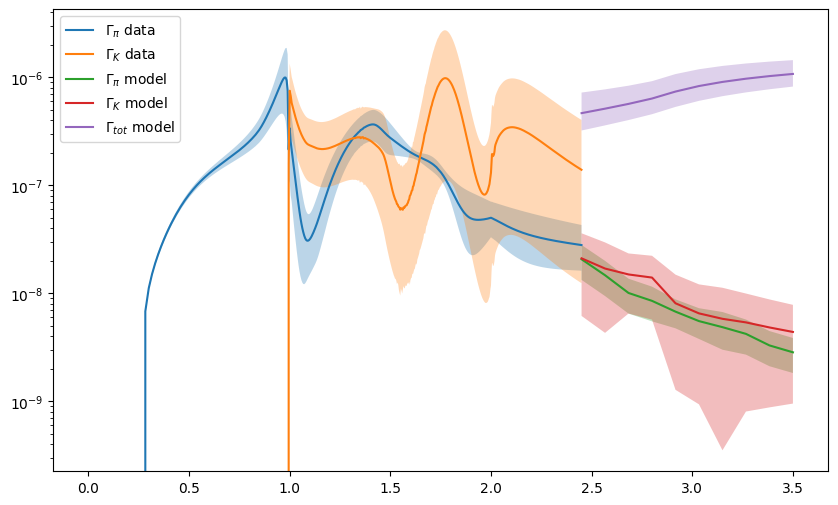

In [63]:
from decay_widths import gg_NNLO,ssbar_NNLO
def plot_decay_widths(m,data):
    fig,ax=plt.subplots(figsize=(10,6))

    gamma_tot=gamma_fac_opt*(gg_NNLO(m,m)+ssbar_NNLO(m,m))

    ax.plot(pi_data[:,0],pi_data[:,1],label=r'$\Gamma_\pi$ data')
    ax.fill_between(pi_data[:,0], pi_data[:,2],pi_data[:,3],alpha=0.3,interpolate=True)
    ax.plot(K_data[:,0],K_data[:,1],label=r'$\Gamma_K$ data')
    ax.fill_between(K_data[:,0], K_data[:,2],K_data[:,3],alpha=0.3,interpolate=True)

    br_pi=np.array([d['pi']['BR central'] for d in data])
    gamma_pi=br_pi*gamma_tot
    br_K=np.array([d['K']['BR central'] for d in data])
    gamma_K=br_K*gamma_tot
    pi_err=np.array([d['pi']['gamma std'] for d in data])
    K_err=np.array([d['K']['gamma std'] for d in data])
    #gamma_tot=np.array([d['total']['gamma mean'] for d in data])
    gamma_err=np.array([d['total']['gamma std'] for d in data])

    ax.plot(m,gamma_pi,label=r'$\Gamma_\pi$ model')
    ax.fill_between(m, gamma_pi-pi_err,gamma_pi+pi_err,alpha=0.3,interpolate=True)
    ax.plot(m,gamma_K,label=r'$\Gamma_K$ model')
    ax.fill_between(m, gamma_K-K_err,gamma_K+K_err,alpha=0.3,interpolate=True)
    ax.plot(m,gamma_tot,label=r'$\Gamma_{tot}$ model')
    #ax.fill_between(m, gamma_tot-gamma_err,gamma_tot+gamma_err,alpha=0.3,interpolate=True)
    ax.fill_between(m, gamma_fac_opt*(gg_NNLO(m,m*2)+ssbar_NNLO(m,m*2)),gamma_fac_opt*(gg_NNLO(m,m/2)+ssbar_NNLO(m,m/2)),alpha=0.3,interpolate=True)

    ax.set_yscale('log')
    ax.legend()
    plt.savefig('/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/pi_K_decay_widths_largewv.pdf')

plot_decay_widths(m_error_fit*1e-3,all_brs2)

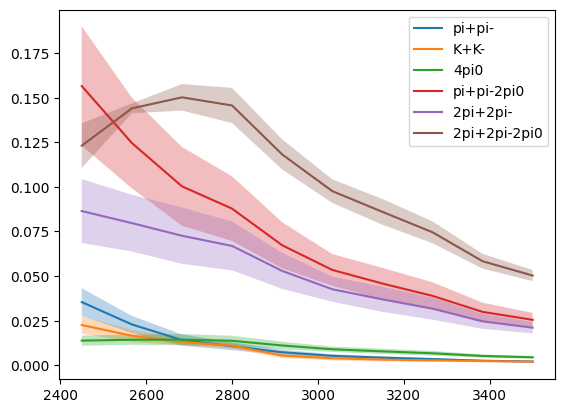

In [34]:
def plot_br_with_error(state,brs,m,label):
    error=np.array([brs[i][state]['BR std'] for i in range(len(m))])
    mean=np.array([brs[i][state]['BR mean'] for i in range(len(m))])
    central=np.array([brs[i][state]['BR central'] for i in range(len(m))])
    #plt.plot(m,mean,label=label)
    plt.plot(m,central,label=label)
    plt.fill_between(m,central+error,central-error,alpha=0.3)
    plt.legend()

plot_br_with_error((-211,211),all_brs2,m_error_fit,label='pi+pi-')
plot_br_with_error((-321,321),all_brs2,m_error_fit,label='K+K-')
plot_br_with_error((111,111,111,111),all_brs2,m_error_fit,label='4pi0')
plot_br_with_error((-211,111,111,211),all_brs2,m_error_fit,label='pi+pi-2pi0')
plot_br_with_error((-211,-211,211,211),all_brs2,m_error_fit,label='2pi+2pi-')
plot_br_with_error((-211,-211,111,111,211,211),all_brs2,m_error_fit,label='2pi+2pi-2pi0')

### minos errors

In [ ]:
parameters_from_minos_fixed_wv=[]
upper_lower_errors={'ws':[0,ws_opt_fixed_wv+ws_upper_fixed_wv],'gamma_fac':[gamma_fac_opt_fixed_wv-gamma_fac_lower_fixed_wv,gamma_fac_opt_fixed_wv+gamma_fac_upper_fixed_wv]}
SH_err=ScalarHadronizer(scalar_mass=2450)
meson_list=SH_err.initialize_meson_list_for_parameter_fits()

def nll_minuit(ws,wv,gamma_fac):
    br_pi,br_K,gamma_pi,gamma_K=SH_err.parameter_fit_func(ws,wv,gamma_fac,meson_list)
    return -logL_model(gamma_pi,gamma_pi_central_last,gamma_pi_upper_last,gamma_pi_lower_last)-logL_model(gamma_K,gamma_K_central_last,gamma_K_upper_last,gamma_K_lower_last)-logL_model(gamma_fac,1,gg_ss_upper/gg_ss_central,gg_ss_lower/gg_ss_central)

for par in ['ws','gamma_fac']:
    for par_val in upper_lower_errors[par]:
        minuit_error = Minuit(nll_minuit, ws=1,wv=0.1,gamma_fac=1)
        minuit_error.limits=[(0,10),(0,1),(0,10)]
        minuit_error.errordef = Minuit.LIKELIHOOD
        minuit_error.fixto(par,par_val)
        minuit_error.fixto('wv',wv_opt+wv_upper)
        minuit_error.migrad()
        parameters_from_minos_fixed_wv.append([minuit_error.params['ws'].value,minuit_error.params['wv'].value,minuit_error.params['gamma_fac'].value])
    
parameters_from_minos_fixed_wv

[[0.0, 0.3499134859803592, 1.152286588071392],
 [9.26999094286045, 0.3499134859803592, 1.0558221614484073],
 [5.68938345166161e-09, 0.3499134859803592, 0.8228951275393286],
 [0.6133166826780783, 0.3499134859803592, 1.80815892653627]]

In [107]:
x=1
SH=ScalarHadronizer(scalar_mass=2700,strange_weight=parameters_from_minos_fixed_wv[x][0],spin_suppression=parameters_from_minos_fixed_wv[x][1],gamma_fac=parameters_from_minos_fixed_wv[x][2])
SH.simulateDecay()
SH.print_final_states(10)

Generated 29 initial meson pairs.
The following final states were generated:
(-211, 111, 211, 337) pi- pi0 pi+ phi(3)(1850) :  0.15283096134700047
(-211, -211, 111, 111, 211, 211) pi- pi- pi0 pi0 pi+ pi+ :  0.12785091761231931
(-211, -211, 111, 130, 211, 321) pi- pi- pi0 K(L)0 pi+ K+ :  0.035876071126087566
(-321, -211, 111, 130, 211, 211) K- pi- pi0 K(L)0 pi+ pi+ :  0.035876071126087566
(-321, -211, 111, 111, 211, 321) K- pi- pi0 pi0 pi+ K+ :  0.03568530764392028
(-211, -211, -211, 111, 211, 211, 321) pi- pi- pi- pi0 pi+ pi+ K+ :  0.024866252614791248
(-321, -211, -211, 111, 211, 211, 211) K- pi- pi- pi0 pi+ pi+ pi+ :  0.024866252614791248
(-211, -211, -211, 111, 111, 111, 211, 211, 211) pi- pi- pi- pi0 pi0 pi0 pi+ pi+ pi+ :  0.020695219407532207
(-321, -211, 111, 211, 321) K- pi- pi0 pi+ K+ :  0.02034606296624622
(-211, 22, 111, 111, 211) pi- gamma pi0 pi0 pi+ :  0.019369403008467848


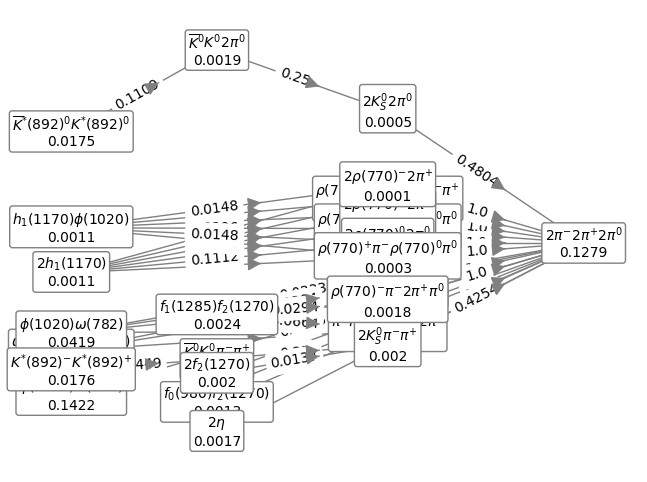

In [108]:
SH.plot_from_final_state((-211,-211,111,111,211,211))

In [94]:
m_error_fit=np.linspace(m_fit,3500,10)
file_path = 'pkls_for_plots/brs_with_errors_minos_largewv.pkl'
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        all_brs = pickle.load(f)
else:
    all_brs=[]
    for mass in m_error_fit:
        print(mass)
        brs_with_errors=compute_errors_from_par_variation(mass,parameters_from_minos_fixed_wv,optimal_values=[ws_opt_fixed_wv,wv_opt_fixed_wv,gamma_fac_opt_fixed_wv])
        all_brs.append(brs_with_errors)

    with open(file_path,'wb') as f:
        pickle.dump(all_brs,f)

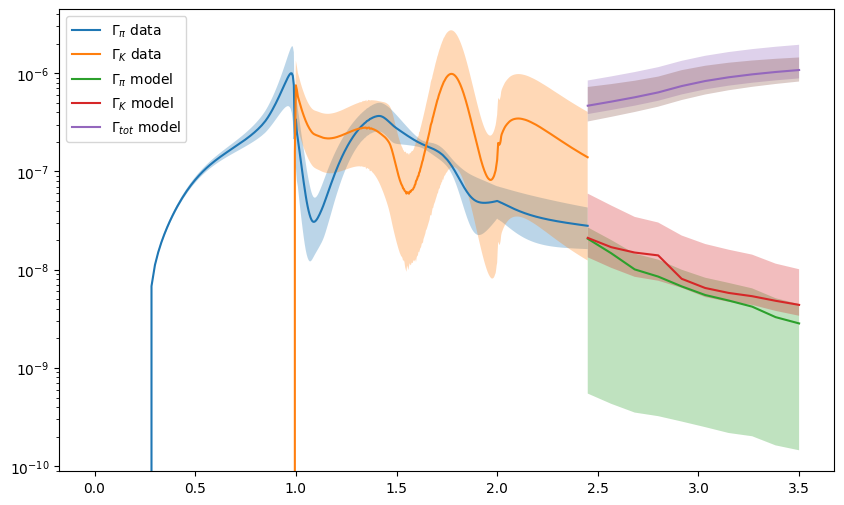

In [95]:
plot_errors_from_par_variation(m_error_fit*1e-3,all_brs,path='/home/henry/Documents/Uni/Masterarbeit/latex-thesis/plots/pi_K_decay_widths_fixed_av.pdf',optimal_values=[ws_opt_fixed_wv,wv_opt_fixed_wv,gamma_fac_opt_fixed_wv])

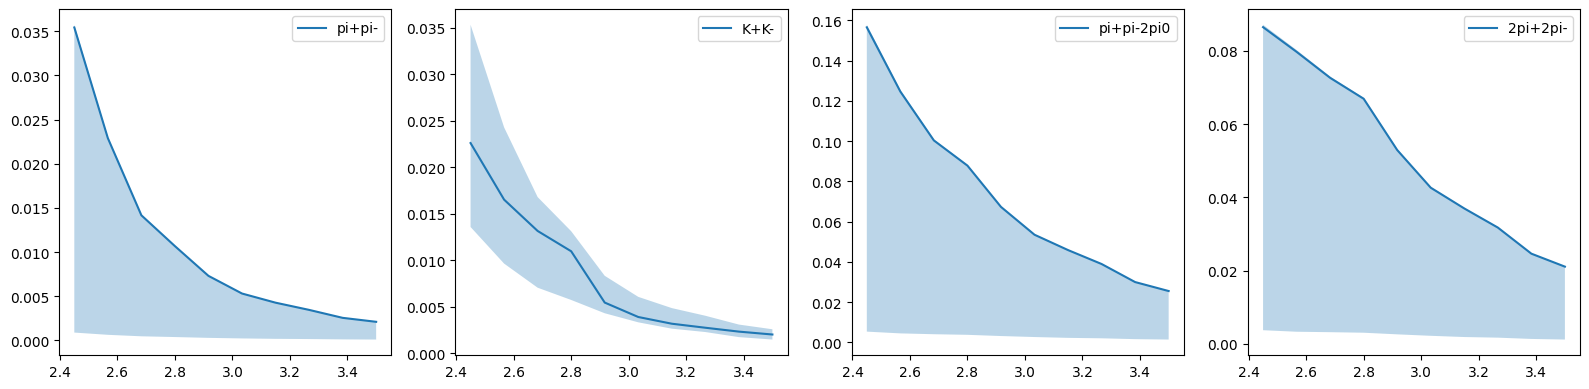

In [89]:
fig,ax=plt.subplots(1,4,figsize=(16,4))
plot_br_with_minos_error(ax[0],(-211,211),all_brs,m_error_fit,label='pi+pi-')
plot_br_with_minos_error(ax[1],(-321,321),all_brs,m_error_fit,label='K+K-')
plot_br_with_minos_error(ax[2],(-211,111,111,211),all_brs,m_error_fit,label='pi+pi-2pi0')
plot_br_with_minos_error(ax[3],(-211,-211,211,211),all_brs,m_error_fit,label='2pi+2pi-')
plt.tight_layout()

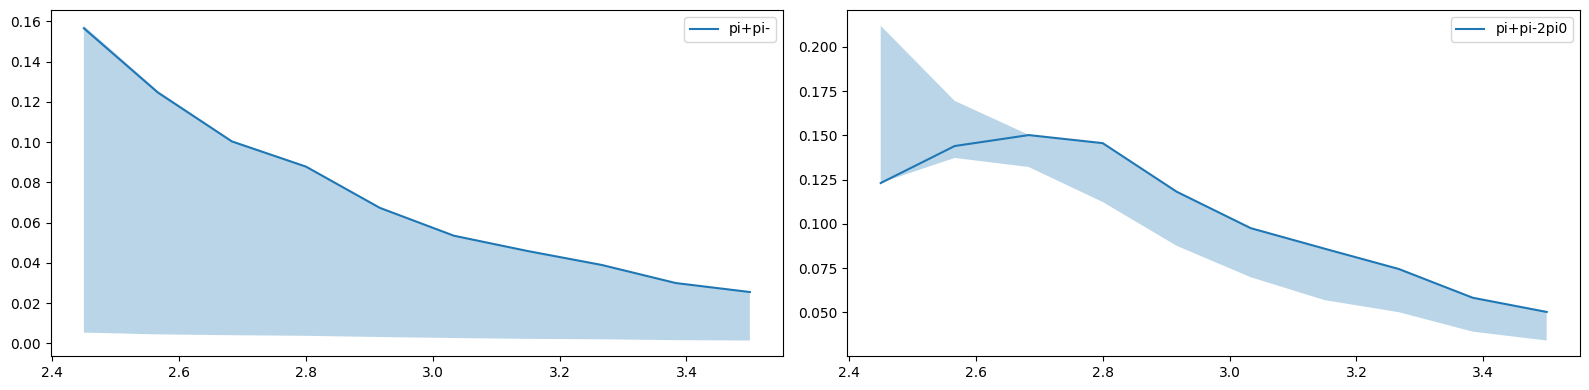

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(16,4))
plot_br_with_minos_error(ax[0],(-211,111,111,211),all_brs,m_error_fit,label='pi+pi-')
plot_br_with_minos_error(ax[1],(-211,-211,111,111,211,211),all_brs,m_error_fit,label='2pi+2pi-2pi0')
plt.tight_layout()